# Inital Setup

In [1]:
#!pip install xgboost

In [2]:
#!pip install tensorflow[and-cuda]
#!pip install wordcloud

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization

import warnings
warnings.filterwarnings("ignore")

# TF-IDF

In [4]:
# Using raw string literal for the file path
file_path = r'C:\Users\Yixuan Liu\Downloads\billboard_grouped.csv'

# Reading the CSV file into a DataFrame
Billboard = pd.read_csv(file_path)

In [5]:
Billboard.head()

Artists                 Name  peak  max_weeks        Date  \
0             Cher              Believe     1         31  1999-07-12   
1              TLC            No Scrubs     1         28  1999-07-12   
2   Jennifer Lopez   If You Had My Love     1         25  1999-07-12   
3  Destiny's Child  Bills, Bills, Bills     1         20  1999-07-12   
4     Ricky Martin  Livin' La Vida Loca     1         20  1999-07-12   

                Genre                                             Lyrics  Pop  \
0           Dance,Pop  Believe \nAfter love, after love\nAfter love, ...    1   
1        Rap,Pop,R&;B  No Scrubs \nA scrub is a guy that thinks he's ...    1   
2            Pop,R&;B  If You Had My Love \nIf you had my love, and I...    1   
3            R&;B,Rap  Bills, Bills, Bills \nAt first we started out ...    0   
4  Pop,Latin Pop,Rock  Living La Vida Loca \nShe's into superstitions...    1   

   Rap  Rock  R&;B  Country  
0    0     0     0        0  
1    1     0     1        0  
2    0     0     1        0  
3    1     0     1        0  
4    0     1     0        0

In [6]:
from collections import Counter

# Assuming 'Billboard' is your DataFrame and you've loaded it with the proper columns
# You can use pandas to read your csv or excel file with Billboard = pd.read_csv('your_file.csv') or pd.read_excel('your_file.xlsx')

# First, let's combine all the genre strings into one big list
genres_combined = Billboard['Genre'].str.cat(sep=',').split(',')

# Now, count the occurrences of each genre using Counter
genre_counts = Counter(genres_combined)

# Convert the genre counts into a DataFrame
genre_tf = pd.DataFrame.from_records(list(dict(genre_counts).items()), columns=['Genre', 'Term Frequency'])

genre_tf_sorted = genre_tf.sort_values(by='Term Frequency', ascending=False)


# Display the term frequencies for each genre
print(genre_tf_sorted)

                 Genre  Term Frequency
1                  Pop            2994
2                  Rap            2465
5                 Rock            1538
3                 R&;B            1335
15             Country            1255
..                 ...             ...
239  Melodic Metalcore               1
232           Merengue               1
221           Big Band               1
212  Football (Soccer)               1
333   Psychedelic Soul               1

[334 rows x 2 columns]


In [7]:

# Get the list of English stopwords and extend it with custom words
stop_words = set(stopwords.words('english'))
custom_stop_words = [
       'ooh', 'yeah', 'hey', 'whoa', 'woah', 'ohh', 'was', 'mmm', 'oooh',
    'yah', 'yeh', 'mmm', 'hmm', 'deh', 'doh', 'jah', 'wa', 'oh', 'na',
    'and', 'you', 'got', 'get', 'nigga', 'fuck', 'bitch', 'pussy', 'damn', 'hoe','shit'
]
banned_words = ['nigga', 'fuck', 'bitch', 'pussy', 'damn', 'hoe', 'shit','fucking']
# Extend the stopwords with banned words
stop_words.update(custom_stop_words)
stop_words.update(banned_words)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define function to process text
def process_text(text):
    # Tokenize the text and convert to lower case
    tokens = word_tokenize(text.lower())
    # Lemmatize and remove stopwords and non-alphabetic tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    # Remove stopwords and banned words
    return ' '.join([token for token in lemmatized_tokens if token not in stop_words])

# Assuming 'Billboard' is your DataFrame and has already been loaded
top_genres = ['Pop', 'Rap', 'Rock', 'R&;B', 'Country']
# Filter songs to include only the top genres
top_genre_songs = Billboard[Billboard['Genre'].str.contains('|'.join(top_genres))]

# Process each genre separately
for genre in top_genres:
    # Filter songs by genre
    genre_songs = top_genre_songs[top_genre_songs['Genre'].str.contains(genre, na=False)]
    # List of lyrics for the current genre
    lyrics_list = genre_songs['Lyrics'].dropna().tolist()
    # Process the lyrics: tokenize, lemmatize, and remove stopwords and banned words
    lyrics_list_processed = [process_text(lyrics) for lyrics in lyrics_list]

    vectorizer = CountVectorizer()

    # Check if there are lyrics to process
    if lyrics_list:
        # Fit the vectorizer to the processed lyrics list
        X = vectorizer.fit_transform(lyrics_list)

        # Check if vocabulary is created
        if vectorizer.vocabulary_:
            # Sum the term frequency across all songs for the current genre
            sum_words = X.sum(axis=0)

            # Get the feature names and corresponding term frequencies
            words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

            # Create a DataFrame with term frequencies
            tf_df = pd.DataFrame(words_freq, columns=['Term', 'Frequency'])

            # Get the top 5 terms for the current genre
            top_terms = tf_df.head(10)

            # Print the top 5 terms
            print(f"Top 10 terms in {genre} lyrics after processing:")
            print(top_terms)
            print("\n")
        else:
            print(f"No vocabulary could be created for genre {genre}, possibly because the lyrics contain only non-content words.")
    else:
        print(f"No lyrics to process for genre {genre}")


Top 10 terms in Pop lyrics after processing:
   Term  Frequency
0   you      57965
1   the      35482
2    it      26676
3    me      25181
4    to      23335
5   and      22679
6    my      16904
7  that      14356
8    oh      14338
9    in      12365


Top 10 terms in Rap lyrics after processing:
   Term  Frequency
0   the      49837
1   you      48408
2    it      33363
3   and      25118
4    me      24628
5    to      23640
6    my      23108
7  that      20371
8    on      17445
9    in      17317


Top 10 terms in Rock lyrics after processing:
   Term  Frequency
0   you      22466
1   the      17634
2   and      11742
3    to      11719
4    it      10483
5    me       9135
6    my       6990
7  that       5974
8    in       5824
9    on       5115


Top 10 terms in R&;B lyrics after processing:
   Term  Frequency
0   you      34153
1   the      17143
2    it      16048
3    me      14484
4    to      12665
5   and      11345
6    my       9354
7  that       8809
8    oh       

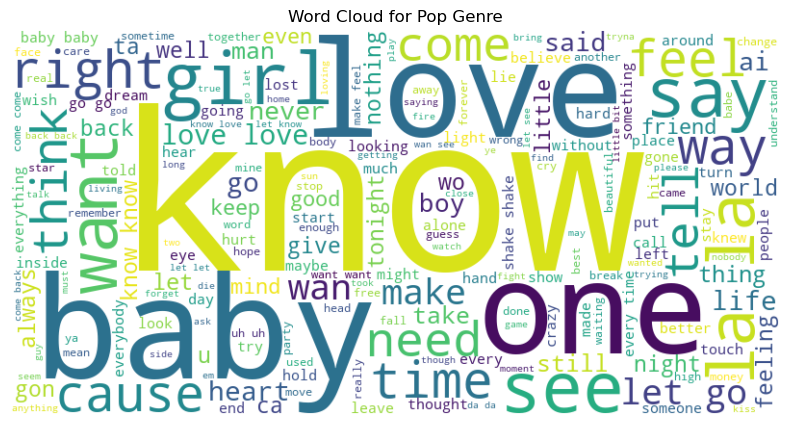

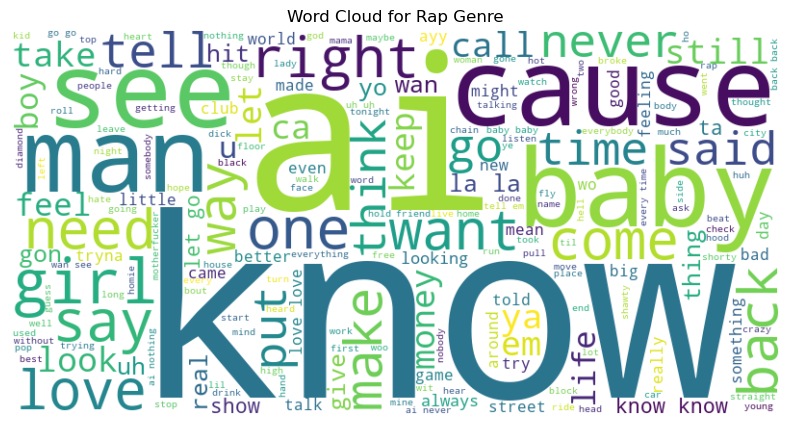

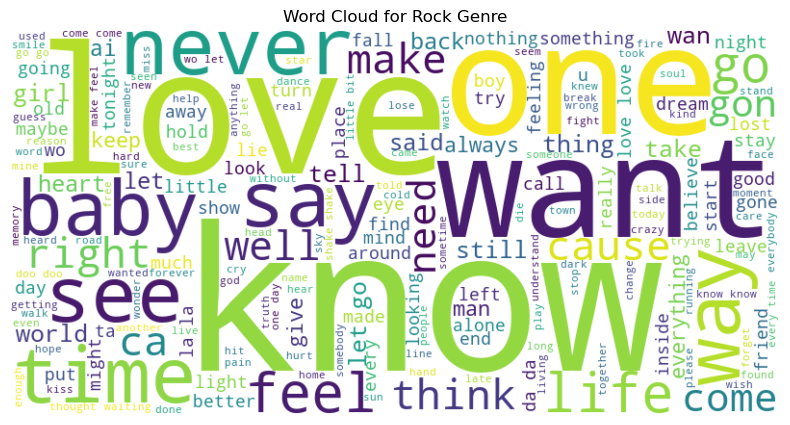

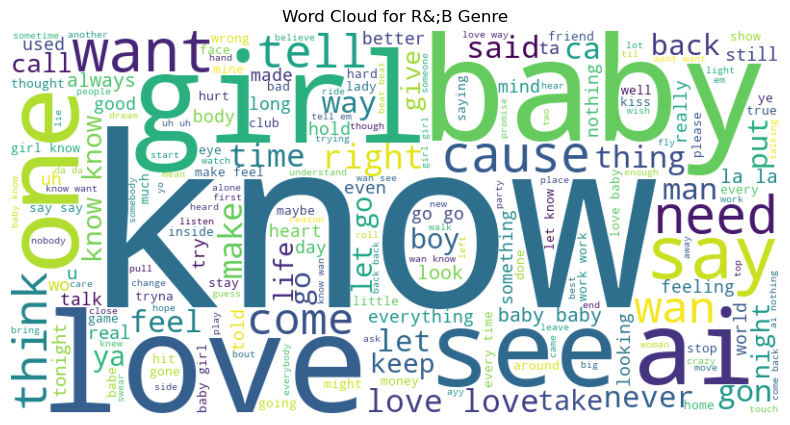

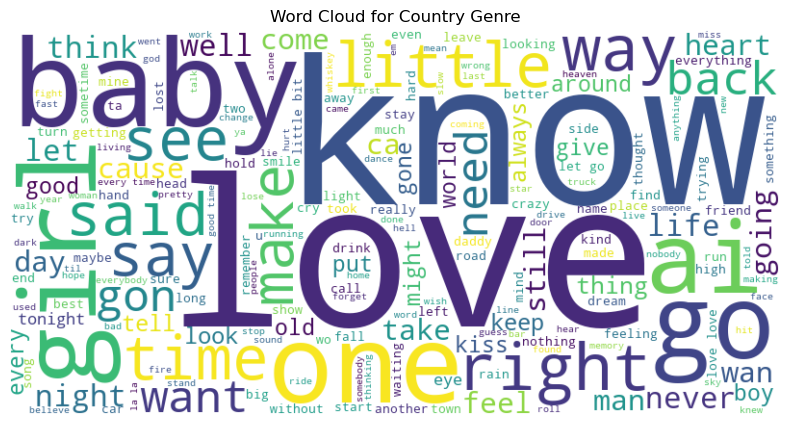

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Now add the word cloud generation and plotting logic
for genre in top_genres:
    # Filter songs by genre
    genre_songs = top_genre_songs[top_genre_songs['Genre'].str.contains(genre, na=False)]
    # List of lyrics for the current genre
    lyrics_list = genre_songs['Lyrics'].dropna().tolist()
    # Process the lyrics: tokenize, lemmatize, and remove stopwords and banned words
    processed_lyrics = ' '.join([process_text(lyrics) for lyrics in lyrics_list])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_lyrics)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axis
    plt.title(f"Word Cloud for {genre} Genre")
    plt.show()

In [9]:
# Get the list of English stopwords and extend it with custom words
stop_words = set(stopwords.words('english'))
new_stop_words = ['ooh', 'yeah', 'hey', 'whoa', 'woah', 'ohh', 'was', 'mmm', 'oooh', 'yah', 'yeh', 'mmm', 'hmm', 'deh', 'doh', 'jah', 'wa', 'oh', 'na', 'and', 'you','get','got','nigga']
stop_words.update(new_stop_words)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Assuming 'Billboard' is your DataFrame and has already been loaded

# Define the top genres
top_genres = ['Pop', 'Rap', 'Rock', 'R&;B', 'Country']

time_periods = [
    (1999, 2009),
    (2009, 2019)
]

# Function to tokenize, lemmatize, and remove stopwords from text
def process_text(text):
    tokens = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

# Analyze each time period and genre
for start_year, end_year in time_periods:
    print(f"Analyzing period: {start_year}-{end_year}")
    for genre in top_genres:
        print(f"Genre: {genre}")
        # Filter songs by genre and time period
        period_genre_songs = Billboard[
            (Billboard['Genre'].str.contains(genre, na=False)) &
            (Billboard['Date'] >= f'{start_year}-01-01') &
            (Billboard['Date'] <= f'{end_year}-12-31')
        ]

        # List of lyrics for the current genre and time period
        lyrics_list = period_genre_songs['Lyrics'].dropna().tolist()

        # Process the lyrics
        lyrics_list = [' '.join(process_text(lyrics)) for lyrics in lyrics_list]

        if lyrics_list:
            # Initialize CountVectorizer
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform(lyrics_list)
            sum_words = X.sum(axis=0)
            words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            tf_df = pd.DataFrame(words_freq, columns=['Term', 'Frequency']).head(10)
            print(tf_df)
        else:
            print(f"No lyrics to process for {genre} in {start_year}-{end_year}")
        print("\n")

Analyzing period: 1999-2009
Genre: Pop
   Term  Frequency
0  love       3993
1  know       3956
2  like       3426
3    go       2639
4  baby       2581
5   let       2315
6  girl       2141
7   one       2019
8  time       2002
9  want       1981


Genre: Rap
   Term  Frequency
0  like       5442
1  know       4026
2  girl       2790
3    ai       2607
4    go       2580
5   let       2563
6  love       2285
7  baby       2282
8   see       2049
9  make       2025


Genre: Rock
    Term  Frequency
0   know       2140
1   like       1873
2   love       1656
3     go       1353
4    one       1195
5   time       1183
6  never       1138
7    say       1131
8    way       1023
9    see       1003


Genre: R&;B
   Term  Frequency
0  know       2902
1  love       2832
2  like       2491
3  baby       2380
4  girl       2273
5    go       1683
6   let       1617
7   wan       1428
8   see       1306
9  want       1262


Genre: Country
     Term  Frequency
0    love       1023
1    like     

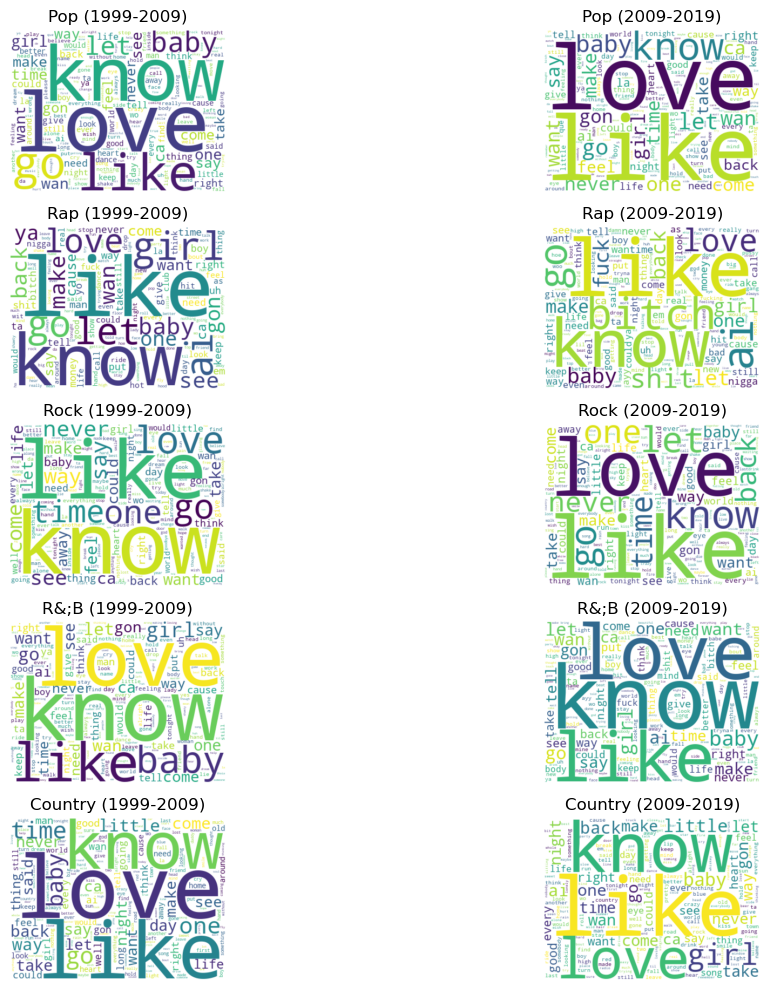

In [10]:

# Convert 'Date' column to datetime
Billboard['Year'] = pd.to_datetime(Billboard['Date']).dt.year

# Define the top genres
top_genres = ['Pop', 'Rap', 'Rock', 'R&;B', 'Country']  # Note the '&' is removed from 'R&;B'

time_periods = [
    (1999, 2009),
    (2009, 2019)
]

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Create subplots for each genre and time period comparison
fig, axes = plt.subplots(nrows=len(top_genres), ncols=len(time_periods), figsize=(14, 2 * len(top_genres)))

for j, genre in enumerate(top_genres):
    for i, (start_year, end_year) in enumerate(time_periods):
        # Filter songs by genre and time period
        period_genre_songs = Billboard[
            Billboard['Genre'].str.contains(genre) &
            (Billboard['Year'] >= start_year) &
            (Billboard['Year'] <= end_year)
        ]

        # List of lyrics for the current genre and time period
        lyrics_list = period_genre_songs['Lyrics'].dropna().tolist()

        # Process the lyrics
        lyrics_list = [' '.join(process_text(lyrics)) for lyrics in lyrics_list]

        # Generate word cloud
        if lyrics_list:
            X = vectorizer.fit_transform(lyrics_list)
            sum_words = X.sum(axis=0)
            words_freq = {word: sum_words[0, idx] for word, idx in vectorizer.vocabulary_.items()}

            wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(words_freq)

            ax = axes[j, i]
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(f"{genre} ({start_year}-{end_year})")
        else:
            axes[j, i].text(0.5, 0.5, f"No data for {genre} ({start_year}-{end_year})", ha='center', va='center')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [11]:
# Get the list of English stopwords and extend it with custom words
stop_words = set(stopwords.words('english'))
new_stop_words = ['ooh', 'yeah', 'hey', 'whoa', 'woah', 'ohh', 'was', 'mmm', 'oooh', 'yah', 'yeh', 'mmm', 'hmm', 'deh', 'doh', 'jah', 'wa', 'oh', 'na', 'and', 'you','nigga ']
stop_words.update(new_stop_words)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the top genres
top_genres = ['Pop', 'Rap', 'Rock', 'R&;B', 'Country']

# Function to tokenize, lemmatize, and remove stopwords from text
def process_text(text):
    tokens = word_tokenize(text.lower())
    return ' '.join(lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words)

# Process and vectorize the lyrics for each genre
for genre in top_genres:
    # Filter the DataFrame for the current genre and process the lyrics
    genre_songs = Billboard[Billboard['Genre'].str.contains(genre, na=False)]
    lyrics_list = genre_songs['Lyrics'].dropna().apply(process_text).tolist()

    # Compute TF-IDF and extract IDF scores
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_list)

    # Get feature names and corresponding IDF scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    idf_scores = tfidf_vectorizer.idf_

    # Create a DataFrame with terms and their IDF scores
    term_idf_df = pd.DataFrame(list(zip(feature_names, idf_scores)), columns=['Term', 'IDF'])

    # Sort by IDF score in descending order and take top 10
    top_terms_idf = term_idf_df.sort_values(by='IDF', ascending=True).head(10)

    print(f"Top 10 most important words for {genre} genre based on IDF scores:")
    print(top_terms_idf)
    print("\n")

Top 10 most important words for Pop genre based on IDF scores:
       Term       IDF
8609   know  1.419447
8955   like  1.506156
6675    got  1.654287
9206   love  1.657292
6618     go  1.738791
6506    get  1.773346
15794  time  1.782174
8877    let  1.833971
10876   one  1.878782
9376   make  1.882545


Top 10 most important words for Rap genre based on IDF scores:
       Term       IDF
11989  like  1.097576
8728    got  1.130648
11472  know  1.187509
8449    get  1.212189
357      ai  1.311957
8637     go  1.416030
12522  make  1.497043
18289   see  1.505719
11886   let  1.508403
1211   back  1.519894


Top 10 most important words for Rock genre based on IDF scores:
       Term       IDF
4684   know  1.537822
4874   like  1.604375
3632     go  1.831559
3666    got  1.839689
5002   love  1.842414
8762   time  1.843779
3567    get  1.863090
5829    one  1.872887
5662  never  1.976530
7317    say  2.000209


Top 10 most important words for R&;B genre based on IDF scores:
      Term    

In [12]:

# Get the list of English stopwords and extend it with custom words
stop_words = set(stopwords.words('english'))
new_stop_words = ['ooh', 'yeah', 'hey', 'whoa', 'woah', 'ohh', 'was', 'mmm', 'oooh', 'yah', 'yeh', 'mmm', 'hmm', 'deh', 'doh', 'jah', 'wa', 'oh', 'na', 'and', 'you','got','get']
stop_words.update(new_stop_words)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Assuming 'Billboard' is your DataFrame and has already been loaded

# Define the top genres
top_genres = ['Pop', 'Rap', 'Rock', 'R&B', 'Country']  # Adjusted 'R&;B' to 'R&B' to match genre naming conventions

# Function to tokenize, lemmatize, and remove stopwords from text
def process_text(text):
    tokens = word_tokenize(text.lower())
    return ' '.join(lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words)

# Combine and process lyrics from all genres
all_lyrics_list = []
for genre in top_genres:
    # Filter the DataFrame for the current genre and process the lyrics
    genre_songs = Billboard[Billboard['Genre'].str.contains(genre, na=False)]
    genre_lyrics_list = genre_songs['Lyrics'].dropna().apply(process_text).tolist()
    all_lyrics_list.extend(genre_lyrics_list)

# Compute TF-IDF for the combined corpus and extract IDF scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_lyrics_list)

# Get feature names and corresponding IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
idf_scores = tfidf_vectorizer.idf_

# Create a DataFrame with terms and their IDF scores
term_idf_df = pd.DataFrame(list(zip(feature_names, idf_scores)), columns=['Term', 'IDF'])

# Sort by IDF score in descending order and take top 15
top_terms_idf = term_idf_df.sort_values(by='IDF', ascending=True).head(15)

print("Top 15 most important words across all genres based on IDF scores:")
print(top_terms_idf)

Top 15 most important words across all genres based on IDF scores:
        Term       IDF
14613   know  1.380050
15248   like  1.384289
11063     go  1.662165
15629   love  1.713954
26893   time  1.763595
18502    one  1.788226
15121    let  1.800000
15934   make  1.805680
23297    see  1.816877
3702      ca  1.865706
23007    say  1.865981
1615    back  1.889355
17871  never  1.911559
26212   take  1.923431
1591    baby  1.928395


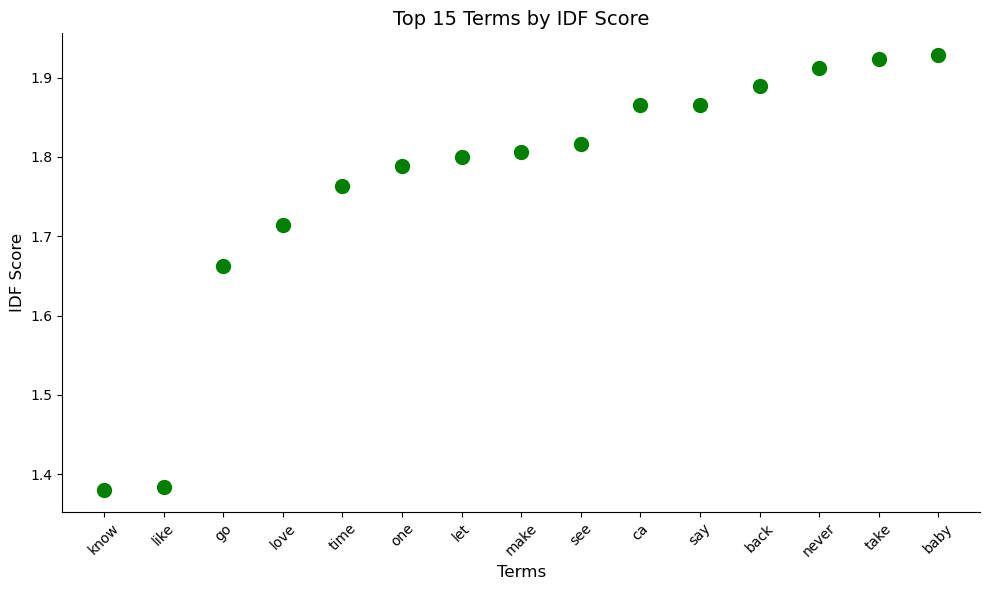

In [13]:
point_size = 100

# scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(top_terms_idf['Term'], top_terms_idf['IDF'], s=point_size, color='green')

plt.title('Top 15 Terms by IDF Score', fontsize=14)
plt.xlabel('Terms', fontsize=12)
plt.ylabel('IDF Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('idf_scatter_plot_improved.png', dpi=300)

plt.show()

# LDA Topic Modeling

In [14]:
# Using raw string literal for the file path
file_path = r'C:\Users\Yixuan Liu\Downloads\billboard_grouped.csv'

# Reading the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [15]:
df['Lyrics'] = df['Lyrics'].apply(lambda x: x.replace("'m", " am").replace("n't", " not").replace("\n", " "))

In [16]:
df['Lyrics'].iloc[0]

"Believe  After love, after love After love, after love After love, after love After love, after love After love, after love No matter how hard I try You keep pushing me aside And I ca not break through There's no talking to you It's so sad that you're leaving It takes time to believe it But after all is said and done You're gonna be the lonely one, oh Do you believe in life after love? I can feel something inside me say I really do not think you're strong enough, no Do you believe in life after love? I can feel something inside me say I really do not think you're strong enough, no What am I supposed to do? Sit around and wait for you? Well, I ca not do that And there's no turning back I need time to move on I need love to feel strong 'Cause I've had time to think it through And maybe I am too good for you, oh Do you believe in life after love? I can feel something inside me say I really do not think you're strong enough, no Do you believe in life after love? I can feel something insid

In [17]:
df.head()

Artists                 Name  peak  max_weeks        Date  \
0             Cher              Believe     1         31  1999-07-12   
1              TLC            No Scrubs     1         28  1999-07-12   
2   Jennifer Lopez   If You Had My Love     1         25  1999-07-12   
3  Destiny's Child  Bills, Bills, Bills     1         20  1999-07-12   
4     Ricky Martin  Livin' La Vida Loca     1         20  1999-07-12   

                Genre                                             Lyrics  Pop  \
0           Dance,Pop  Believe  After love, after love After love, af...    1   
1        Rap,Pop,R&;B  No Scrubs  A scrub is a guy that thinks he's f...    1   
2            Pop,R&;B  If You Had My Love  If you had my love, and I ...    1   
3            R&;B,Rap  Bills, Bills, Bills  At first we started out r...    0   
4  Pop,Latin Pop,Rock  Living La Vida Loca  She's into superstitions ...    1   

   Rap  Rock  R&;B  Country  
0    0     0     0        0  
1    1     0     1        0  
2    0     0     1        0  
3    1     0     1        0  
4    0     1     0        0

In [18]:
df['Year'] = df['Date'].str[0:4].astype(int)

## Songs from 1999 to 2009

In [19]:
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from nltk.tokenize import RegexpTokenizer
lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df[df['Year']<=2009]['Lyrics'].values:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

# remove words with less than 3 characters

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

# group inflected forms of words

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the filtered tokens

lemmatized_tokens = []
for lyrics in lyric_corpus_tokenized:
  lemmatized_tokens.append([lemmatizer.lemmatize(word) for word in lyrics])

profanities = []
with open(r'C:\Users\Yixuan Liu\Downloads\profanity.txt', 'r') as file:
    prof_string = file.read().replace('\n', '')
    prof_tokens = prof_string.split(",")
    for token in prof_tokens:
        profanities.append(token)

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in profanities:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_words = stopwords.words('english')

new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
stop_words.extend(new_stop_words)
for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

from gensim.corpora import Dictionary
dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_above = 0.8)

corpus = [dictionary.doc2bow(lyric) for lyric in lyric_corpus_tokenized]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42,passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

[nltk_data] Downloading package punkt to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topics:
Topic 0: 0.022*"love" + 0.017*"know" + 0.013*"never" + 0.012*"like" + 0.011*"time" + 0.010*"one" + 0.010*"say" + 0.009*"cause" + 0.009*"life" + 0.008*"way"
Topic 1: 0.028*"girl" + 0.023*"wanna" + 0.023*"know" + 0.022*"get" + 0.022*"baby" + 0.021*"want" + 0.019*"got" + 0.017*"like" + 0.014*"love" + 0.014*"let"
Topic 2: 0.030*"like" + 0.021*"get" + 0.019*"got" + 0.012*"know" + 0.011*"let" + 0.010*"back" + 0.008*"make" + 0.008*"see" + 0.007*"cause" + 0.007*"money"


In [20]:
from gensim.corpora import Dictionary
dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_above = 0.8)

corpus = [dictionary.doc2bow(lyric) for lyric in lyric_corpus_tokenized]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, random_state=42,passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topics:
Topic 0: 0.014*"away" + 0.011*"never" + 0.009*"life" + 0.009*"heart" + 0.009*"day" + 0.009*"take" + 0.008*"one" + 0.008*"like" + 0.007*"would" + 0.007*"back"
Topic 1: 0.048*"get" + 0.024*"man" + 0.015*"got" + 0.013*"woman" + 0.012*"want" + 0.011*"like" + 0.011*"cause" + 0.011*"ama" + 0.010*"know" + 0.009*"back"
Topic 2: 0.038*"like" + 0.023*"got" + 0.020*"get" + 0.016*"know" + 0.010*"see" + 0.010*"back" + 0.008*"money" + 0.008*"put" + 0.008*"make" + 0.008*"cause"
Topic 3: 0.047*"let" + 0.032*"get" + 0.028*"dance" + 0.021*"shake" + 0.020*"like" + 0.020*"gonna" + 0.017*"party" + 0.016*"girl" + 0.015*"body" + 0.014*"wanna"
Topic 4: 0.024*"like" + 0.024*"want" + 0.013*"home" + 0.012*"dem" + 0.011*"girls" + 0.010*"bad" + 0.010*"rain" + 0.010*"girl" + 0.010*"come" + 0.010*"swing"
Topic 5: 0.023*"little" + 0.023*"gone" + 0.020*"que" + 0.014*"goes" + 0.013*"time" + 0.012*"world" + 0.010*"bit" + 0.010*"long" + 0.009*"waiting" + 0.008*"soul"
Topic 6: 0.039*"love" + 0.034*"know" + 0.016*"

In [21]:
from gensim.models.coherencemodel import CoherenceModel
coherencemodel = CoherenceModel(model=lda_model, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.37050526562075237


In [22]:
!pip install pyLDAvis

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)
#pyLDAvis.save_html(vis_data, './Lyrics_LDA_k_'+ str(5) +'.html')

## Songs from 2009 to 2019

In [24]:
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from nltk.tokenize import RegexpTokenizer
lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df[df['Year']>2009]['Lyrics'].values:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

# remove words with less than 3 characters

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

# group inflected forms of words

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the filtered tokens

lemmatized_tokens = []
for lyrics in lyric_corpus_tokenized:
  lemmatized_tokens.append([lemmatizer.lemmatize(word) for word in lyrics])

profanities = []
with open(r'C:\Users\Yixuan Liu\Downloads\profanity.txt', 'r') as file:
    prof_string = file.read().replace('\n', '')
    prof_tokens = prof_string.split(",")
    for token in prof_tokens:
        profanities.append(token)

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in profanities:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_words = stopwords.words('english')

new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
stop_words.extend(new_stop_words)
for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

from gensim.corpora import Dictionary
dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_above = 0.8)

corpus = [dictionary.doc2bow(lyric) for lyric in lyric_corpus_tokenized]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, random_state=42,passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

[nltk_data] Downloading package punkt to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topics:
Topic 0: 0.023*"like" + 0.016*"back" + 0.013*"night" + 0.011*"feel" + 0.011*"light" + 0.010*"come" + 0.008*"let" + 0.008*"get" + 0.007*"every" + 0.007*"got"
Topic 1: 0.053*"love" + 0.046*"que" + 0.015*"like" + 0.014*"boo" + 0.013*"talk" + 0.012*"hol" + 0.009*"walk" + 0.009*"baby" + 0.008*"quiero" + 0.008*"hallelujah"
Topic 2: 0.034*"baby" + 0.029*"girl" + 0.027*"wanna" + 0.019*"like" + 0.017*"little" + 0.017*"gonna" + 0.016*"get" + 0.015*"let" + 0.014*"got" + 0.014*"night"
Topic 3: 0.027*"way" + 0.021*"like" + 0.019*"know" + 0.013*"girls" + 0.013*"run" + 0.013*"work" + 0.011*"say" + 0.011*"gon" + 0.010*"right" + 0.010*"said"
Topic 4: 0.034*"know" + 0.025*"love" + 0.018*"like" + 0.016*"never" + 0.014*"let" + 0.014*"one" + 0.014*"baby" + 0.014*"cause" + 0.012*"say" + 0.011*"got"
Topic 5: 0.029*"like" + 0.028*"got" + 0.021*"get" + 0.012*"money" + 0.009*"know" + 0.007*"make" + 0.007*"ayy" + 0.007*"back" + 0.007*"gon" + 0.006*"ama"
Topic 6: 0.042*"new" + 0.029*"boy" + 0.025*"like" +

In [25]:
from gensim.models.coherencemodel import CoherenceModel
coherencemodel = CoherenceModel(model=lda_model, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.3431841892571679


In [26]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

# Pop Songs

In [27]:
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from nltk.tokenize import RegexpTokenizer
lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df[df['Pop']==1]['Lyrics'].values:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

# remove words with less than 3 characters

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

# group inflected forms of words

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the filtered tokens

lemmatized_tokens = []
for lyrics in lyric_corpus_tokenized:
  lemmatized_tokens.append([lemmatizer.lemmatize(word) for word in lyrics])

profanities = []
with open(r'C:\Users\Yixuan Liu\Downloads\profanity.txt', 'r') as file:
    prof_string = file.read().replace('\n', '')
    prof_tokens = prof_string.split(",")
    for token in prof_tokens:
        profanities.append(token)

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in profanities:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_words = stopwords.words('english')

new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
stop_words.extend(new_stop_words)
for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

from gensim.corpora import Dictionary
dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_above = 0.8)

corpus = [dictionary.doc2bow(lyric) for lyric in lyric_corpus_tokenized]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42,passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

[nltk_data] Downloading package punkt to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topics:
Topic 0: 0.035*"love" + 0.019*"know" + 0.013*"never" + 0.013*"let" + 0.012*"like" + 0.011*"cause" + 0.010*"baby" + 0.010*"could" + 0.009*"way" + 0.009*"say"
Topic 1: 0.028*"que" + 0.024*"baby" + 0.016*"like" + 0.014*"got" + 0.013*"let" + 0.013*"get" + 0.011*"love" + 0.010*"body" + 0.009*"low" + 0.009*"come"
Topic 2: 0.029*"like" + 0.021*"know" + 0.019*"got" + 0.019*"get" + 0.014*"girl" + 0.012*"wanna" + 0.012*"baby" + 0.011*"one" + 0.010*"want" + 0.010*"cause"


In [28]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)
#pyLDAvis.save_html(vis_data, './Lyrics_LDA_k_'+ str(5) +'.html')

## Rap Songs

In [29]:
lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df[df['Rap']==1]['Lyrics'].values:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

# remove words with less than 3 characters

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

# group inflected forms of words
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the filtered tokens
lemmatized_tokens = []
for lyrics in lyric_corpus_tokenized:
  lemmatized_tokens.append([lemmatizer.lemmatize(word) for word in lyrics])

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in profanities:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_above = 0.8)

corpus = [dictionary.doc2bow(lyric) for lyric in lyric_corpus_tokenized]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42,passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topics:
Topic 0: 0.022*"baby" + 0.016*"let" + 0.013*"make" + 0.012*"girl" + 0.010*"right" + 0.009*"wanna" + 0.008*"see" + 0.008*"love" + 0.008*"one" + 0.008*"come"
Topic 1: 0.011*"money" + 0.009*"back" + 0.008*"ayy" + 0.007*"woo" + 0.006*"gang" + 0.006*"bad" + 0.006*"gon" + 0.005*"put" + 0.005*"new" + 0.005*"lil"
Topic 2: 0.014*"love" + 0.011*"cause" + 0.010*"say" + 0.010*"never" + 0.009*"want" + 0.008*"let" + 0.008*"one" + 0.008*"wanna" + 0.008*"see" + 0.008*"back"


In [30]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

## Country Songs

In [31]:
lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df[df['Country']==1]['Lyrics'].values:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

# remove words with less than 3 characters

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

# group inflected forms of words
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the filtered tokens
lemmatized_tokens = []
for lyrics in lyric_corpus_tokenized:
  lemmatized_tokens.append([lemmatizer.lemmatize(word) for word in lyrics])

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in profanities:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes()

corpus = [dictionary.doc2bow(lyric) for lyric in lyric_corpus_tokenized]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42,passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topics:
Topic 0: 0.013*"baby" + 0.011*"back" + 0.011*"night" + 0.010*"come" + 0.009*"every" + 0.009*"get" + 0.009*"time" + 0.009*"girl" + 0.009*"see" + 0.009*"got"
Topic 1: 0.032*"love" + 0.016*"baby" + 0.014*"gonna" + 0.014*"one" + 0.014*"wanna" + 0.013*"never" + 0.011*"make" + 0.011*"let" + 0.011*"get" + 0.011*"got"
Topic 2: 0.019*"little" + 0.017*"got" + 0.009*"back" + 0.009*"girl" + 0.008*"get" + 0.008*"said" + 0.008*"man" + 0.008*"old" + 0.008*"right" + 0.007*"one"


In [32]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [33]:
df.columns

Index(['Artists', 'Name', 'peak', 'max_weeks', 'Date', 'Genre', 'Lyrics',
       'Pop', 'Rap', 'Rock', 'R&;B', 'Country', 'Year'],
      dtype='object')

## R&;B Songs

In [34]:
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from nltk.tokenize import RegexpTokenizer
lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df[df['R&;B']==1]['Lyrics'].values:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

# remove words with less than 3 characters

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

# group inflected forms of words

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the filtered tokens

lemmatized_tokens = []
for lyrics in lyric_corpus_tokenized:
  lemmatized_tokens.append([lemmatizer.lemmatize(word) for word in lyrics])

profanities = []
with open(r'C:\Users\Yixuan Liu\Downloads\profanity.txt', 'r') as file:
    prof_string = file.read().replace('\n', '')
    prof_tokens = prof_string.split(",")
    for token in prof_tokens:
        profanities.append(token)

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in profanities:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_words = stopwords.words('english')

new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
stop_words.extend(new_stop_words)
for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

from gensim.corpora import Dictionary
dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_above = 0.8)

corpus = [dictionary.doc2bow(lyric) for lyric in lyric_corpus_tokenized]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42,passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

[nltk_data] Downloading package punkt to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topics:
Topic 0: 0.029*"know" + 0.020*"like" + 0.017*"say" + 0.013*"love" + 0.012*"tell" + 0.012*"get" + 0.012*"come" + 0.012*"girl" + 0.010*"want" + 0.010*"cause"
Topic 1: 0.031*"like" + 0.025*"get" + 0.022*"got" + 0.022*"baby" + 0.021*"know" + 0.017*"girl" + 0.012*"let" + 0.011*"want" + 0.011*"put" + 0.010*"wanna"
Topic 2: 0.043*"love" + 0.021*"baby" + 0.020*"know" + 0.016*"wanna" + 0.016*"one" + 0.015*"let" + 0.012*"never" + 0.012*"girl" + 0.012*"cause" + 0.011*"got"


In [35]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

## BERTopics

In [36]:
#pip install --upgrade pip

In [37]:
#pip install hdbscan

In [38]:
#!pip install bertopic

In [39]:
from bertopic import BERTopic

D:\Anaconda\Lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
D:\Anaconda\Lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
D:\Anaconda\Lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
D:\Anaconda\Lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
D:\Anaconda\Lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packa

In [41]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform([" ".join(song) for song in lyric_corpus_tokenized])

In [42]:
topic_model.get_topic_info().head(7).set_index('Topic')[
   ['Count', 'Name', 'Representation']]

Count                     Name  \
Topic                                   
-1       609   -1_know_like_baby_love   
 0       399      0_like_get_know_got   
 1       142    1_love_know_heart_one   
 2        75     2_girl_back_like_say   
 3        35     3_love_bye_baby_like   
 4        32  4_rain_life_ruin_energy   
 5        28    5_baby_want_girl_love   

                                          Representation  
Topic                                                     
-1     [know, like, baby, love, got, wanna, girl, get...  
 0     [like, get, know, got, girl, let, baby, come, ...  
 1     [love, know, heart, one, time, cause, way, bab...  
 2     [girl, back, like, say, mind, time, get, know,...  
 3     [love, bye, baby, like, let, way, never, woman...  
 4     [rain, life, ruin, energy, night, faith, lucky...  
 5     [baby, want, girl, love, time, talk, see, say,...

In [43]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

D:\Anaconda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [44]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform([" ".join(song) for song in lyric_corpus_tokenized])
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)
topic_model.get_topic_info().head(7).set_index('Topic')[
   ['Count', 'Name', 'Representation']]

Count                     Name  \
Topic                                   
-1       795   -1_know_like_baby_girl   
 0       193    0_love_know_heart_one   
 1       109     1_get_like_got_money   
 2        80     2_time_got_like_back   
 3        46    3_baby_girl_body_know   
 4        30  4_solo_friends_lit_know   
 5        28    5_dance_step_turn_let   

                                          Representation  
Topic                                                     
-1     [know, like, baby, girl, got, love, get, wanna...  
 0     [love, know, heart, one, cause, time, want, ne...  
 1     [get, like, got, money, know, let, drop, bubbl...  
 2     [time, got, like, back, know, could, cause, pu...  
 3     [baby, girl, body, know, got, like, make, bed,...  
 4     [solo, friends, lit, know, right, business, no...  
 5     [dance, step, turn, let, wanna, love, play, to...

In [45]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

D:\Anaconda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [46]:
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from nltk.tokenize import RegexpTokenizer
lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df['Lyrics'].values:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

# remove words with less than 3 characters

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

# group inflected forms of words

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the filtered tokens

lemmatized_tokens = []
for lyrics in lyric_corpus_tokenized:
  lemmatized_tokens.append([lemmatizer.lemmatize(word) for word in lyrics])

profanities = []
with open(r'C:\Users\Yixuan Liu\Downloads\profanity.txt', 'r') as file:
    prof_string = file.read().replace('\n', '')
    prof_tokens = prof_string.split(",")
    for token in prof_tokens:
        profanities.append(token)

for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in profanities:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_words = stopwords.words('english')

new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
stop_words.extend(new_stop_words)
for s,song in enumerate(lyric_corpus_tokenized):
    filtered_text = []
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

from gensim.corpora import Dictionary
dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_above = 0.8)

corpus = [dictionary.doc2bow(lyric) for lyric in lyric_corpus_tokenized]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42,passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

[nltk_data] Downloading package punkt to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topics:
Topic 0: 0.028*"que" + 0.009*"boo" + 0.008*"girls" + 0.007*"run" + 0.006*"new" + 0.005*"solo" + 0.005*"country" + 0.005*"baby" + 0.005*"quiero" + 0.005*"world"
Topic 1: 0.022*"love" + 0.021*"know" + 0.016*"like" + 0.014*"baby" + 0.011*"let" + 0.011*"one" + 0.010*"never" + 0.010*"cause" + 0.010*"time" + 0.009*"wanna"
Topic 2: 0.028*"like" + 0.022*"got" + 0.019*"get" + 0.011*"know" + 0.008*"back" + 0.007*"money" + 0.007*"let" + 0.007*"gon" + 0.007*"make" + 0.006*"put"


In [47]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform([" ".join(song) for song in lyric_corpus_tokenized])
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)
topic_model.get_topic_info().head(7).set_index('Topic')[
   ['Count', 'Name', 'Representation']]

Count                          Name  \
Topic                                        
0       7082          0_like_know_got_love   
1         85          1_que_por_quiero_con   
2         46  2_christmas_santa_merry_year   

                                          Representation  
Topic                                                     
0      [like, know, got, love, get, baby, let, cause,...  
1      [que, por, quiero, con, mas, como, amor, una, ...  
2      [christmas, santa, merry, year, jingle, time, ...

In [48]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

D:\Anaconda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Sentiment Analysis

In [49]:
# read data by not using index
file_path = r'C:\Users\Yixuan Liu\Downloads\billboard_grouped.csv'
data = pd.read_csv(file_path)

In [50]:
def preprocess_lyrics(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Re-join tokens into a string
    return ' '.join(tokens)

In [51]:
data['processed_lyrics'] = data['Lyrics'].apply(preprocess_lyrics)

In [52]:
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
# Sentiment analysis for 'lyrics' column
data['nltk_sentiments'] = data['processed_lyrics'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [53]:
# Define a function that categorizes sentiment based on the value
def categorize_sentiment(score):
    if score >= 0.3:
        return 'Positive'
    elif score <= -0.3:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the 'nltk_sentiments' column to create a new column
data['sentiment_category'] = data['nltk_sentiments'].apply(categorize_sentiment)

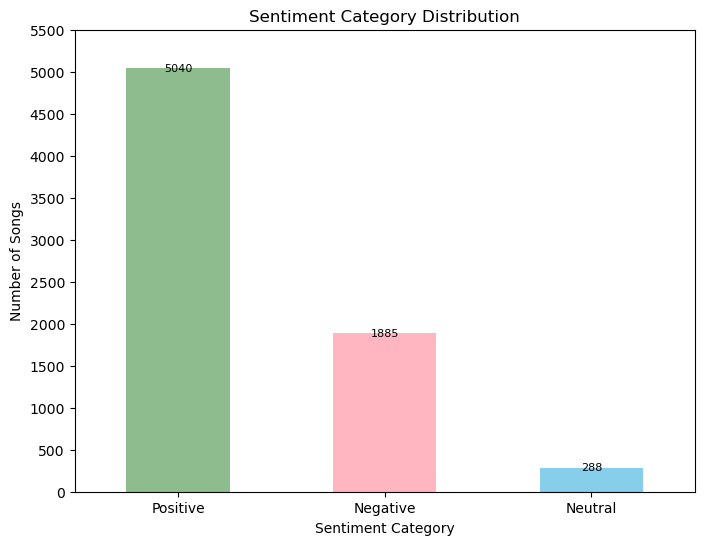

In [54]:
# Count the occurrences of each sentiment category
sentiment_counts = data['sentiment_category'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = sentiment_counts.plot(kind='bar', color=['darkseagreen', 'lightpink', 'skyblue'])
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Songs')
plt.yticks(range(0, max(sentiment_counts) + 500, 500))
plt.xticks(rotation=0)  # Keep the category labels horizontal

# Annotate the bars with the exact numbers
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 35, str(int(bar.get_height())),
             ha='center', color='black', fontsize=8)

plt.show()

In [55]:
def get_avg_polarity(data):
    scores = data['nltk_sentiments'].values.tolist()
    return len(scores), sum(scores) / len(scores)

In [56]:
data_len, data_polarity = get_avg_polarity(data)
print(f'Overall (num={data_len}) Polarity:', data_polarity)

Overall (num=7213) Polarity: 0.422502176625536


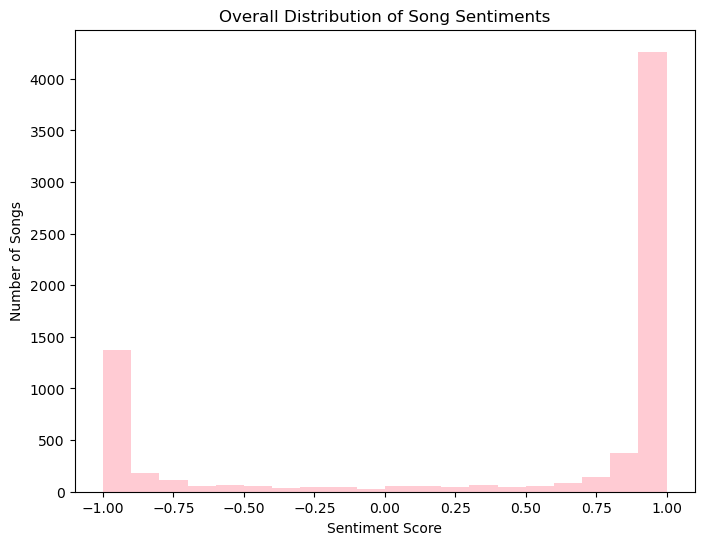

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(data['nltk_sentiments'], bins=20, alpha=0.7, color='lightpink')
plt.title('Overall Distribution of Song Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Songs')
plt.grid(False)
plt.show()

## Look at Sentiment by Genre

In [58]:
pop_len, pop_polarity = get_avg_polarity(data[data['Genre'] == 'Pop'])
rock_len, rock_polarity = get_avg_polarity(data[data['Genre'] == 'Rock'])
country_len, country_polarity = get_avg_polarity(data[data['Genre'] == 'Country'])
rap_len, rap_polarity = get_avg_polarity(data[data['Genre'] == 'Rap'])
rnb_len, rnb_polarity = get_avg_polarity(data[data['Genre'] == 'R&;B'])

# print the polarity of each genre
print()
print(f'Pop (num={pop_len}) Polarity:', pop_polarity)
print(f'Rock (num={rock_len}) Polarity:', rock_polarity)
print(f'Country (num={country_len}) Polarity:', country_polarity)
print(f'Rap (num={rap_len}) Polarity:', rap_polarity)
print(f'R&B (num={rnb_len}) Polarity:', rnb_polarity)


Pop (num=719) Polarity: 0.6139015299026418
Rock (num=255) Polarity: 0.4548003921568627
Country (num=675) Polarity: 0.6251619259259261
Rap (num=800) Polarity: 0.13171574999999988
R&B (num=184) Polarity: 0.7034179347826083


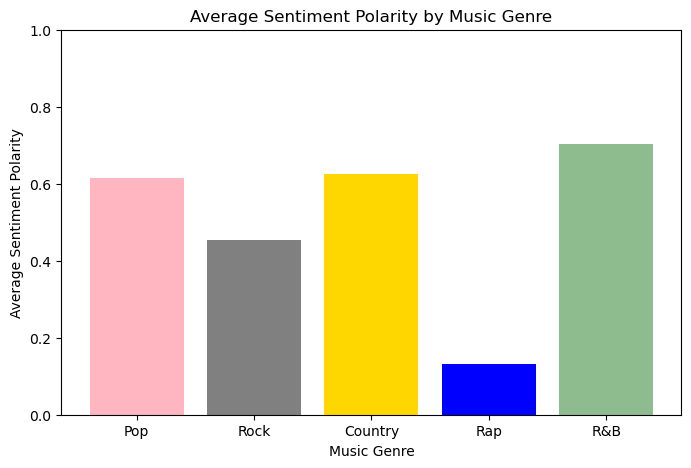

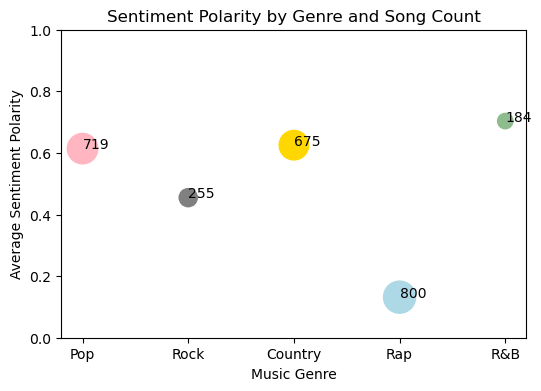

In [59]:
# Given data from your sentiment analysis
genres = ['Pop', 'Rock', 'Country', 'Rap', 'R&B']
polarities = [0.6139015299026418, 0.4548003921568627, 0.6251619259259261, 0.13171574999999988, 0.7034179347826083]
counts = [719, 255, 675, 800, 184]

# Create a bar chart for sentiment polarity
plt.figure(figsize=(8, 5))
plt.bar(genres, polarities, color=['lightpink', 'grey', 'gold', 'blue', 'darkseagreen'])
plt.xlabel('Music Genre')
plt.ylabel('Average Sentiment Polarity')
plt.title('Average Sentiment Polarity by Music Genre')
plt.ylim(0, 1)  # Assuming polarity ranges from 0 to 1
plt.show()

# Create a scatter plot for sentiment polarity with the size representing the number of songs
plt.figure(figsize=(6, 4))
sizes = [count / 1.5 for count in counts]  # Adjust the size to a suitable scale for your plot
plt.scatter(genres, polarities, s=sizes, color=['lightpink', 'grey', 'gold', 'lightblue', 'darkseagreen'])
plt.xlabel('Music Genre')
plt.ylabel('Average Sentiment Polarity')
plt.title('Sentiment Polarity by Genre and Song Count')
plt.ylim(0, 1)  # Assuming polarity ranges from 0 to 1
for i, txt in enumerate(counts):
    plt.annotate(txt, (genres[i], polarities[i]))
plt.show()

## look at Sentiment Trend in 5-year Buskets

In [60]:
# split the data by 5 years from 1999 to 2019, the date is "YYYY-MM-DD"
data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Day'] = pd.to_datetime(data['Date']).dt.day

In [61]:
# get the polarity of the lyrics by 5 years
data_1999_2003_len, data_1999_2003_polarity = get_avg_polarity(data[(data['Year'] >= 1999) & (data['Year'] <= 2003)])
data_2004_2008_len, data_2004_2008_polarity = get_avg_polarity(data[(data['Year'] >= 2004) & (data['Year'] <= 2008)])
data_2009_2013_len, data_2009_2013_polarity = get_avg_polarity(data[(data['Year'] >= 2009) & (data['Year'] <= 2013)])
data_2014_2019_len, data_2014_2019_polarity = get_avg_polarity(data[(data['Year'] >= 2014) & (data['Year'] <= 2019)])

# print the polarity of the lyrics by 5 years
print(f'1999-2003 (num={data_1999_2003_len}) Polarity:', data_1999_2003_polarity)
print(f'2004-2008 (num={data_2004_2008_len}) Polarity:', data_2004_2008_polarity)
print(f'2009-2013 (num={data_2009_2013_len}) Polarity:', data_2009_2013_polarity)
print(f'2014-2019 (num={data_2014_2019_len}) Polarity:', data_2014_2019_polarity)

1999-2003 (num=1319) Polarity: 0.5155458680818797
2004-2008 (num=1613) Polarity: 0.4902938003719764
2009-2013 (num=1952) Polarity: 0.43990235655737703
2014-2019 (num=2329) Polarity: 0.3082738943752684


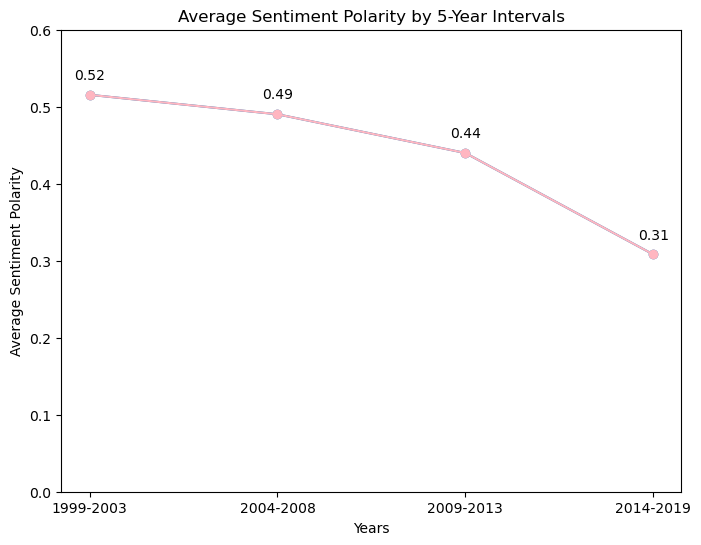

In [62]:
# Assuming you have the following data from your sentiment analysis
years = ['1999-2003', '2004-2008', '2009-2013', '2014-2019']
polarities = [0.5155, 0.4902,0.4399, 0.3082]

plt.figure(figsize=(8, 6))
plt.plot(years, polarities, marker='o')  # 'o' for a circular marker at each data point
plt.plot(years, polarities, marker='o', color='lightpink')

# Adding titles and labels
plt.title('Average Sentiment Polarity by 5-Year Intervals')
plt.xlabel('Years')
plt.ylabel('Average Sentiment Polarity')

# Optionally, you can also add a grid for better readability
plt.grid(False)

# Set the y-axis range from 0 to 1
plt.ylim(0, 0.6)

# Adding labels for each data point
for i, txt in enumerate(polarities):
    plt.text(years[i], polarities[i] + 0.02, f'{txt:.2f}', ha='center')

# Show the plot
plt.show()

## look at Sentiment Trend by Genre in 5-year Buskets 

In [63]:
# get the polarity of the lyrics by 5 years and by genre
pop_1999_2003_len, pop_1999_2003_polarity = get_avg_polarity(data[(data['Year'] >= 1999) & (data['Year'] <= 2003) & (data['Genre'] == 'Pop')])
rock_1999_2003_len, rock_1999_2003_polarity = get_avg_polarity(data[(data['Year'] >= 1999) & (data['Year'] <= 2003) & (data['Genre'] == 'Rock')])
country_1999_2003_len, country_1999_2003_polarity = get_avg_polarity(data[(data['Year'] >= 1999) & (data['Year'] <= 2003) & (data['Genre'] == 'Country')])
rap_1999_2003_len, rap_1999_2003_polarity = get_avg_polarity(data[(data['Year'] >= 1999) & (data['Year'] <= 2003) & (data['Genre'] == 'Rap')])
rnb_1999_2003_len, rnb_1999_2003_polarity = get_avg_polarity(data[(data['Year'] >= 1999) & (data['Year'] <= 2003) & (data['Genre'] == 'R&;B')])

pop_2004_2008_len, pop_2004_2008_polarity = get_avg_polarity(data[(data['Year'] >= 2004) & (data['Year'] <= 2008) & (data['Genre'] == 'Pop')])
rock_2004_2008_len, rock_2004_2008_polarity = get_avg_polarity(data[(data['Year'] >= 2004) & (data['Year'] <= 2008) & (data['Genre'] == 'Rock')])
country_2004_2008_len, country_2004_2008_polarity = get_avg_polarity(data[(data['Year'] >= 2004) & (data['Year'] <= 2008) & (data['Genre'] == 'Country')])
rap_2004_2008_len, rap_2004_2008_polarity = get_avg_polarity(data[(data['Year'] >= 2004) & (data['Year'] <= 2008) & (data['Genre'] == 'Rap')])
rnb_2004_2008_len, rnb_2004_2008_polarity = get_avg_polarity(data[(data['Year'] >= 2004) & (data['Year'] <= 2008) & (data['Genre'] == 'R&;B')])

pop_2009_2013_len, pop_2009_2013_polarity = get_avg_polarity(data[(data['Year'] >= 2009) & (data['Year'] <= 2013) & (data['Genre'] == 'Pop')])
rock_2009_2013_len, rock_2009_2013_polarity = get_avg_polarity(data[(data['Year'] >= 2009) & (data['Year'] <= 2013) & (data['Genre'] == 'Rock')])
country_2009_2013_len, country_2009_2013_polarity = get_avg_polarity(data[(data['Year'] >= 2009) & (data['Year'] <= 2013) & (data['Genre'] == 'Country')])
rap_2009_2013_len, rap_2009_2013_polarity = get_avg_polarity(data[(data['Year'] >= 2009) & (data['Year'] <= 2013) & (data['Genre'] == 'Rap')])
rnb_2009_2013_len, rnb_2009_2013_polarity = get_avg_polarity(data[(data['Year'] >= 2009) & (data['Year'] <= 2013) & (data['Genre'] == 'R&;B')])

pop_2014_2019_len, pop_2014_2019_polarity = get_avg_polarity(data[(data['Year'] >= 2014) & (data['Year'] <= 2019) & (data['Genre'] == 'Pop')])
rock_2014_2019_len, rock_2014_2019_polarity = get_avg_polarity(data[(data['Year'] >= 2014) & (data['Year'] <= 2019) & (data['Genre'] == 'Rock')])
country_2014_2019_len, country_2014_2019_polarity = get_avg_polarity(data[(data['Year'] >= 2014) & (data['Year'] <= 2019) & (data['Genre'] == 'Country')])
rap_2014_2019_len, rap_2014_2019_polarity = get_avg_polarity(data[(data['Year'] >= 2014) & (data['Year'] <= 2019) & (data['Genre'] == 'Rap')])
rnb_2014_2019_len, rnb_2014_2019_polarity = get_avg_polarity(data[(data['Year'] >= 2014) & (data['Year'] <= 2019) & (data['Genre'] == 'R&;B')])

# print the polarity of the lyrics by 5 years and by genre
print(f'1999-2003 Pop (num={pop_1999_2003_len}) Polarity:', pop_1999_2003_polarity)
print(f'2004-2008 Pop (num={pop_2004_2008_len}) Polarity:', pop_2004_2008_polarity)
print(f'2009-2013 Pop (num={pop_2009_2013_len}) Polarity:', pop_2009_2013_polarity)
print(f'2014-2019 Pop (num={pop_2014_2019_len}) Polarity:', pop_2014_2019_polarity)

print()
print(f'1999-2003 Rock (num={rock_1999_2003_len}) Polarity:', rock_1999_2003_polarity)
print(f'2004-2008 Rock (num={rock_2004_2008_len}) Polarity:', rock_2004_2008_polarity)
print(f'2009-2013 Rock (num={rock_2009_2013_len}) Polarity:', rock_2009_2013_polarity)
print(f'2014-2019 Rock (num={rock_2014_2019_len}) Polarity:', rock_2014_2019_polarity)

print()
print(f'1999-2003 Country (num={country_1999_2003_len}) Polarity:', country_1999_2003_polarity)
print(f'2004-2008 Country (num={country_2004_2008_len}) Polarity:', country_2004_2008_polarity)
print(f'2009-2013 Country (num={country_2009_2013_len}) Polarity:', country_2009_2013_polarity)
print(f'2014-2019 Country (num={country_2014_2019_len}) Polarity:', country_2014_2019_polarity)

print()
print(f'1999-2003 Rap (num={rap_1999_2003_len}) Polarity:', rap_1999_2003_polarity)
print(f'2004-2008 Rap (num={rap_2004_2008_len}) Polarity:', rap_2004_2008_polarity)
print(f'2009-2013 Rap (num={rap_2009_2013_len}) Polarity:', rap_2009_2013_polarity)
print(f'2014-2019 Rap (num={rap_2014_2019_len}) Polarity:', rap_2014_2019_polarity)

print()
print(f'1999-2003 R&B (num={rap_1999_2003_len}) Polarity:', rnb_1999_2003_polarity)
print(f'2004-2008 R&B (num={rap_2004_2008_len}) Polarity:', rnb_2004_2008_polarity)
print(f'2009-2013 R&B (num={rap_2009_2013_len}) Polarity:', rnb_2009_2013_polarity)
print(f'2014-2019 R&B (num={rap_2014_2019_len}) Polarity:', rnb_2014_2019_polarity)

1999-2003 Pop (num=206) Polarity: 0.6690645631067959
2004-2008 Pop (num=204) Polarity: 0.5976117647058823
2009-2013 Pop (num=211) Polarity: 0.5446218009478674
2014-2019 Pop (num=98) Polarity: 0.6810193877551023

1999-2003 Rock (num=57) Polarity: 0.5596210526315788
2004-2008 Rock (num=112) Polarity: 0.41007946428571435
2009-2013 Rock (num=77) Polarity: 0.475144155844156
2014-2019 Rock (num=9) Polarity: 0.17341111111111107

1999-2003 Country (num=138) Polarity: 0.7024427536231883
2004-2008 Country (num=145) Polarity: 0.6383186206896548
2009-2013 Country (num=107) Polarity: 0.5834411214953271
2014-2019 Country (num=285) Polarity: 0.5967115789473684

1999-2003 Rap (num=150) Polarity: 0.22028400000000004
2004-2008 Rap (num=233) Polarity: 0.3231244635193137
2009-2013 Rap (num=234) Polarity: 0.038772222222222215
2014-2019 Rap (num=183) Polarity: -0.0657415300546448

1999-2003 R&B (num=150) Polarity: 0.7523987012987013
2004-2008 R&B (num=233) Polarity: 0.8184779999999999
2009-2013 R&B (num=234

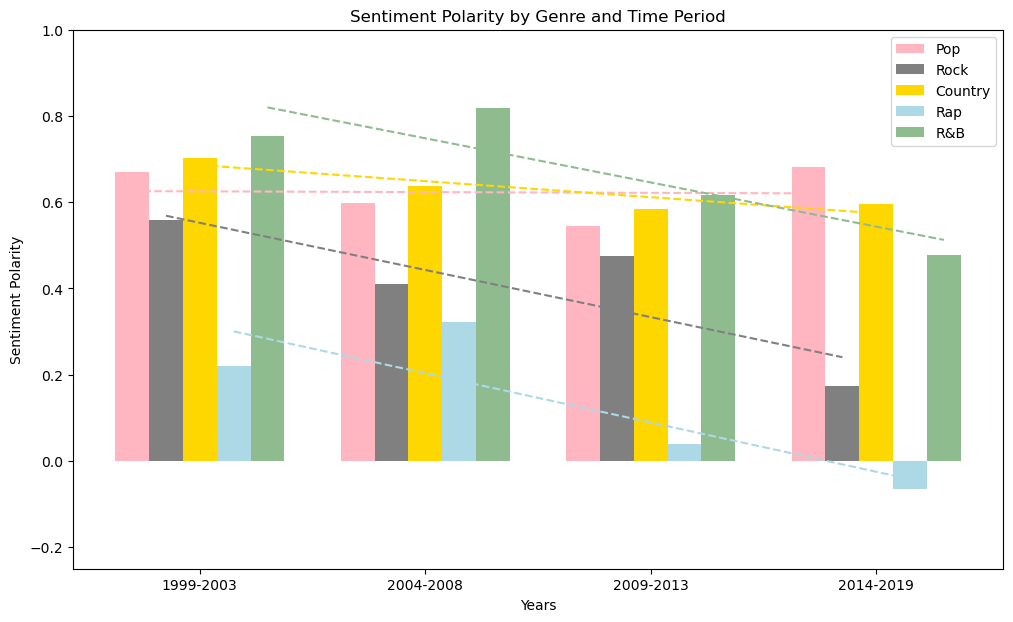

In [64]:
# Sample data from your sentiment analysis results
years = ['1999-2003', '2004-2008', '2009-2013', '2014-2019']
years_numerical = np.arange(len(years))  # Represent years as numerical values for trend line calculation
genres = ['Pop', 'Rock', 'Country', 'Rap', 'R&B']
polarity = {
    'Pop': [0.6690645631067959, 0.5976117647058823, 0.5446218009478674, 0.6810193877551023],
    'Rock': [0.5596210526315788, 0.41007946428571435,  0.475144155844156, 0.17341111111111107],
    'Country': [ 0.7024427536231883, 0.6383186206896548, 0.5834411214953271, 0.5967115789473684],
    'Rap': [0.22028400000000004, 0.3231244635193137, 0.038772222222222215, -0.0657415300546448],
    'R&B': [0.7523987012987013,0.8184779999999999, 0.6157416666666667, 0.478560606060606]
}

# Colors and trend line styles for each genre
colors = {
    'Pop': 'lightpink',
    'Rock': 'grey',
    'Country': 'gold',
    'Rap': 'lightblue',
    'R&B': 'darkseagreen'
}

fig, ax = plt.subplots(figsize=(12, 7))

# Set up the x-axis for the grouped bar chart
num_years = len(years)
x = np.arange(num_years)
bar_width = 0.15  # Adjust width to fit all genres

# Create bars and trend lines for each genre
for i, genre in enumerate(genres):
    # Plot bars
    ax.bar(x + i * bar_width, polarity[genre], width=bar_width, label=genre, color=colors[genre])

    # Calculate and plot trend lines
    z = np.polyfit(years_numerical, polarity[genre], 1)
    p = np.poly1d(z)
    plt.plot(years_numerical + i * bar_width, p(years_numerical), linestyle='--', color=colors[genre])

# Add labels and titles
ax.set_xlabel('Years')
ax.set_ylabel('Sentiment Polarity')
ax.set_title('Sentiment Polarity by Genre and Time Period')
ax.set_xticks(x + bar_width * (len(genres) - 1) / 2)
ax.set_xticklabels(years)
ax.set_ylim(-0.25, 1)

# Add a legend
ax.legend()

# Show the plot
plt.show()



# Prediction Models

In [65]:
# Using raw string literal for the file path
file_path = r'C:\Users\Yixuan Liu\Downloads\billboard_grouped.csv'

# Reading the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [66]:
df

Artists                 Name  peak  max_weeks  \
0                       Cher              Believe     1         31   
1                        TLC            No Scrubs     1         28   
2             Jennifer Lopez   If You Had My Love     1         25   
3            Destiny's Child  Bills, Bills, Bills     1         20   
4               Ricky Martin  Livin' La Vida Loca     1         20   
...                      ...                  ...   ...        ...   
7208      Lil Nas X, Cardi B                Rodeo    22          1   
7209  Marshmello, Kane Brown      One Thing Right    57          1   
7210                Lil Baby          Out The Mud    72          1   
7211     Megan Thee Stallion            Cash Shit    98          1   
7212           Martin Garrix          Summer Days   100          1   

            Date                                              Genre  \
0     1999-07-12                                          Dance,Pop   
1     1999-07-12                                       Rap,Pop,R&;B   
2     1999-07-12                                           Pop,R&;B   
3     1999-07-12                                           R&;B,Rap   
4     1999-07-12                                 Pop,Latin Pop,Rock   
...          ...                                                ...   
7208  2019-07-06  Country,Atlanta,East Coast,Trap,Country Rap,Hi...   
7209  2019-07-06                                                Pop   
7210  2019-07-06                                   Atlanta,Trap,Rap   
7211  2019-07-06                                     East Coast,Rap   
7212  2019-07-06  Electronic Pop,Electro,Electro House,Nederland...   

                                                 Lyrics  Pop  Rap  Rock  R&;B  \
0     Believe \nAfter love, after love\nAfter love, ...    1    0     0     0   
1     No Scrubs \nA scrub is a guy that thinks he's ...    1    1     0     1   
2     If You Had My Love \nIf you had my love, and I...    1    0     0     1   
3     Bills, Bills, Bills \nAt first we started out ...    0    1     0     1   
4     Living La Vida Loca \nShe's into superstitions...    1    0     1     0   
...                                                 ...  ...  ...   ...   ...   
7208  Rodeo \nDaytrip took it to 10 Hey\nOh, here we...    0    1     0     0   
7209  One Thing Right \nI've cheated and I've lied\n...    1    0     0     0   
7210  Out the Mud \nCook that shit up, Quay\nLil Bab...    0    1     0     0   
7211  Cash Shit \nReal hot girl shit\nYeah, I'm in m...    0    1     0     0   
7212  Summer Days \nI got this feeling on a summer d...    1    1     0     0   

      Country  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
7208        1  
7209        0  
7210        0  
7211        0  
7212        0  

[7213 rows x 12 columns]

In [67]:
df.isnull().sum()

Artists      0
Name         0
peak         0
max_weeks    0
Date         0
Genre        0
Lyrics       0
Pop          0
Rap          0
Rock         0
R&;B         0
Country      0
dtype: int64

In [68]:
idx = df.groupby(['Artists', 'Name'])['max_weeks'].idxmax()

In [69]:
df_max_weeks_per_song = df.loc[idx]

In [70]:
df_clean = df_max_weeks_per_song.sort_values('Name')

In [71]:
df_clean['Lyrics'] = df_clean['Lyrics'].str.replace('\n', '', regex=False)

In [72]:
# Initialize StandardScaler
scaler = StandardScaler()

# Inverse the peak position and scale
df_clean['Inverse Peak'] = 1 / df_clean['peak']
df_clean['Normalized Peak'] = scaler.fit_transform(df_clean[['Inverse Peak']])  # Scaling

# Scale Weeks on Chart
df_clean['Normalized Weeks'] = scaler.fit_transform(df_clean[['max_weeks']])

# Combine the normalized scores
df_clean['Popularity'] = df_clean['Normalized Peak'] + df_clean['Normalized Weeks']

D:\Anaconda\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

D:\Anaconda\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead

In [73]:
df_clean = df_clean.sort_values('Popularity', ascending = False)

In [74]:
df_clean

Artists                     Name  peak  max_weeks        Date  \
5984         Ed Sheeran             Shape Of You     1         59  2017-01-28   
5743  Justin Timberlake  Can't Stop The Feeling!     1         52  2016-05-28   
5096       Taylor Swift             Shake It Off     1         50  2014-09-05   
6428              Drake               God's Plan     1         36  2018-02-03   
5455      Justin Bieber        What Do You Mean?     1         31  2015-09-18   
...                 ...                      ...   ...        ...         ...   
6384            Shakira               Perro Fiel   100          1  2017-12-16   
1795               Beck                     Girl   100          1  2005-08-17   
7117      Nipsey Hussle              Victory Lap   100          1  2019-04-20   
3504          Rick Ross               Super High   100          1  2010-06-10   
6182             Halsey                Strangers   100          1  2017-06-17   

                                                  Genre  \
5984                    Tropical House,Dancehall,Pop,UK   
5743                                    Screen,Pop,R&;B   
5096                                      Dance-Pop,Pop   
6428                        Hip-Hop,Trap,Pop,Rap,Canada   
5455   Canada,Tropical House,Electro-Pop,Electronic,Pop   
...                                                 ...   
6384                              En Espa\xc3\xb1ol,Pop   
1795  Adult Alternative,Pop-Rock,Experimental Folk,E...   
7117                                     West Coast,Rap   
3504                                                Rap   
6182  Alternative Pop,Alternative,Pop,Synth-Pop,Danc...   

                                                 Lyrics  Pop  Rap  Rock  R&;B  \
5984  Shape of You The club isn't the best place to ...    1    0     0     0   
5743  CAN'T STOP THE FEELING! I got this feeling ins...    1    0     0     1   
5096  Shake It Off I stay out too lateGot nothing in...    1    0     0     0   
6428  God's Plan And they wishing and wishing and wi...    1    1     0     0   
5455  What Do You Mean? What do you mean? Oh, ohWhen...    1    0     0     0   
...                                                 ...  ...  ...   ...   ...   
6384  Perro Fiel Aqui estasYa no puedes detenerte¿Do...    1    0     0     0   
1795  Girl I saw her, yeah I saw her with her black ...    1    0     1     0   
7117  Victory Lap Whoa, oh-whoa, whoa, ohhLike the b...    0    1     0     0   
3504  Super High Remix You think you got the bond ca...    0    1     0     0   
6182  Strangers She doesn't kiss me on the mouth any...    1    0     0     0   

      Country  Inverse Peak  Normalized Peak  Normalized Weeks  Popularity  
5984        0          1.00        11.714576          4.123389   15.837965  
5743        0          1.00        11.714576          3.485907   15.200483  
5096        0          1.00        11.714576          3.303769   15.018345  
6428        0          1.00        11.714576          2.028805   13.743381  
5455        0          1.00        11.714576          1.573460   13.288036  
...       ...           ...              ...               ...         ...  
6384        0          0.01        -0.198278         -1.158606   -1.356884  
1795        0          0.01        -0.198278         -1.158606   -1.356884  
7117        0          0.01        -0.198278         -1.158606   -1.356884  
3504        0          0.01        -0.198278         -1.158606   -1.356884  
6182        0          0.01        -0.198278         -1.158606   -1.356884  

[7213 rows x 16 columns]

In [75]:
df_clean.reset_index(inplace = True, drop = True)

Text(0.5, 1.0, 'Popularity Count')

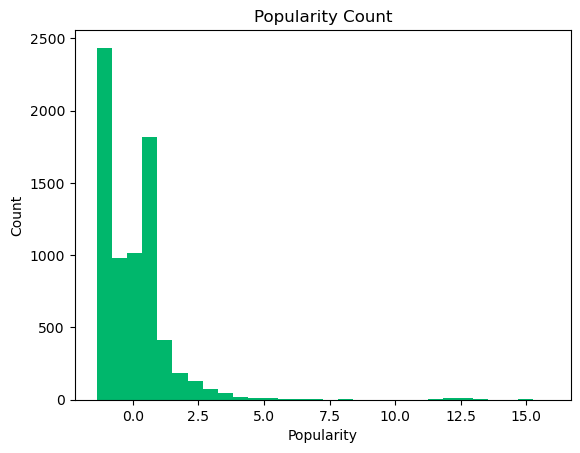

In [76]:
plt.hist(df_clean['Popularity'], bins = 30, color = '#00b76c')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.title('Popularity Count')

In [77]:
offset = abs(df_clean['Popularity'].min()) + 1
df_clean['Adjusted_popularity'] = df_clean['Popularity'] + offset
df_clean['Log_popularity'] = np.log(df_clean['Adjusted_popularity'])

Text(0.5, 1.0, 'Log_popularity Count')

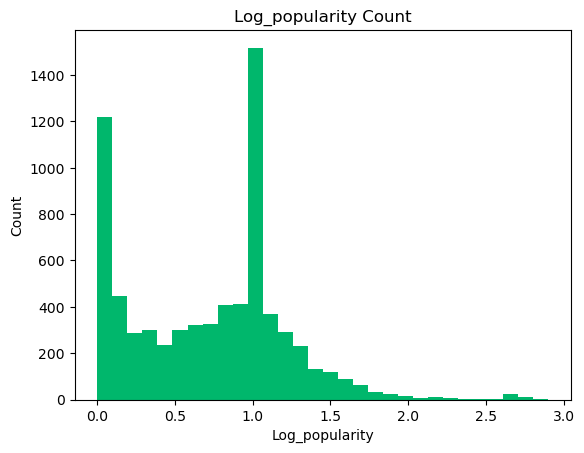

In [78]:
plt.hist(df_clean['Log_popularity'], bins = 30, color = '#00b76c')
plt.xlabel('Log_popularity')
plt.ylabel('Count')
plt.title('Log_popularity Count')

In [79]:
df_clean

Artists                     Name  peak  max_weeks        Date  \
0            Ed Sheeran             Shape Of You     1         59  2017-01-28   
1     Justin Timberlake  Can't Stop The Feeling!     1         52  2016-05-28   
2          Taylor Swift             Shake It Off     1         50  2014-09-05   
3                 Drake               God's Plan     1         36  2018-02-03   
4         Justin Bieber        What Do You Mean?     1         31  2015-09-18   
...                 ...                      ...   ...        ...         ...   
7208            Shakira               Perro Fiel   100          1  2017-12-16   
7209               Beck                     Girl   100          1  2005-08-17   
7210      Nipsey Hussle              Victory Lap   100          1  2019-04-20   
7211          Rick Ross               Super High   100          1  2010-06-10   
7212             Halsey                Strangers   100          1  2017-06-17   

                                                  Genre  \
0                       Tropical House,Dancehall,Pop,UK   
1                                       Screen,Pop,R&;B   
2                                         Dance-Pop,Pop   
3                           Hip-Hop,Trap,Pop,Rap,Canada   
4      Canada,Tropical House,Electro-Pop,Electronic,Pop   
...                                                 ...   
7208                              En Espa\xc3\xb1ol,Pop   
7209  Adult Alternative,Pop-Rock,Experimental Folk,E...   
7210                                     West Coast,Rap   
7211                                                Rap   
7212  Alternative Pop,Alternative,Pop,Synth-Pop,Danc...   

                                                 Lyrics  Pop  Rap  Rock  R&;B  \
0     Shape of You The club isn't the best place to ...    1    0     0     0   
1     CAN'T STOP THE FEELING! I got this feeling ins...    1    0     0     1   
2     Shake It Off I stay out too lateGot nothing in...    1    0     0     0   
3     God's Plan And they wishing and wishing and wi...    1    1     0     0   
4     What Do You Mean? What do you mean? Oh, ohWhen...    1    0     0     0   
...                                                 ...  ...  ...   ...   ...   
7208  Perro Fiel Aqui estasYa no puedes detenerte¿Do...    1    0     0     0   
7209  Girl I saw her, yeah I saw her with her black ...    1    0     1     0   
7210  Victory Lap Whoa, oh-whoa, whoa, ohhLike the b...    0    1     0     0   
7211  Super High Remix You think you got the bond ca...    0    1     0     0   
7212  Strangers She doesn't kiss me on the mouth any...    1    0     0     0   

      Country  Inverse Peak  Normalized Peak  Normalized Weeks  Popularity  \
0           0          1.00        11.714576          4.123389   15.837965   
1           0          1.00        11.714576          3.485907   15.200483   
2           0          1.00        11.714576          3.303769   15.018345   
3           0          1.00        11.714576          2.028805   13.743381   
4           0          1.00        11.714576          1.573460   13.288036   
...       ...           ...              ...               ...         ...   
7208        0          0.01        -0.198278         -1.158606   -1.356884   
7209        0          0.01        -0.198278         -1.158606   -1.356884   
7210        0          0.01        -0.198278         -1.158606   -1.356884   
7211        0          0.01        -0.198278         -1.158606   -1.356884   
7212        0          0.01        -0.198278         -1.158606   -1.356884   

      Adjusted_popularity  Log_popularity  
0               18.194849        2.901139  
1               17.557367        2.865474  
2               17.375229        2.855046  
3               16.100265        2.778836  
4               15.644920        2.750146  
...                   ...             ...  
7208             1.000000        0.000000  
7209             1.000000        0.000000  
7210             1.000000   

In [80]:
#att = pd.read_csv('/content/drive/My Drive/BillboardFromLast20/songAttributes_1999-2019.csv', index_col = 0).reset_index(drop = True)

In [81]:
#common_df = df_clean.merge(att, how = 'left', left_on='Name', right_on='Name')

In [82]:
#common_df.isnull().sum()

In [83]:
#common_df

[nltk_data] Downloading package punkt to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Yixuan
[nltk_data]     Liu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


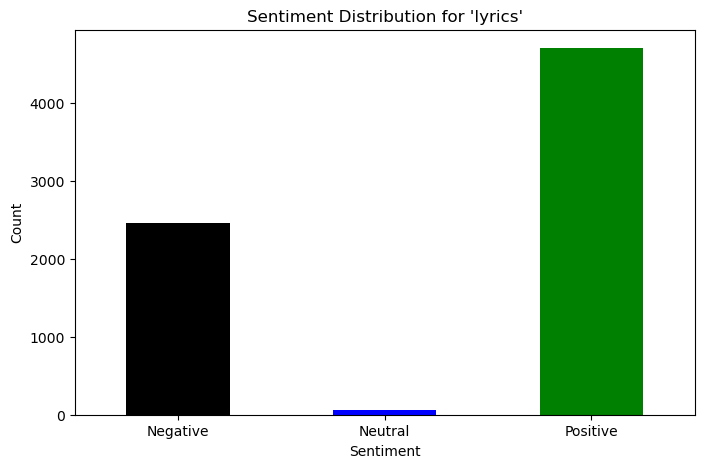

In [84]:
# Step 1: Tokenization
nltk.download('punkt')
nltk.download('wordnet')
df_clean['tokens_lyrics'] = df_clean['Lyrics'].apply(lambda x: word_tokenize(x))

# Step 2: Text Cleaning
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df_clean['processed_lyrics'] = df_clean['tokens_lyrics'].apply(lambda x: [word.lower() for word in x if word.isalnum() and word.lower() not in stop_words])
lemmatizer = WordNetLemmatizer()
df_clean['cleaned_lyrics'] = df_clean['processed_lyrics'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])

# Step 3: Keyword Extraction using TF-IDF
tfidf_vectorizer_lyrics = TfidfVectorizer(max_features=500)  # For 'title' column

tfidf_lyrics = tfidf_vectorizer_lyrics.fit_transform(df_clean['cleaned_lyrics'].apply(lambda x: ' '.join(x)))

# Step 4: Sentiment Analysis
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
# Sentiment analysis for 'title' column
df_clean['sentiment_lyrics'] = df_clean['Lyrics'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_clean['sentiment_label_lyrics'] = df_clean['sentiment_lyrics'].apply(lambda score: 'Positive' if score >= 0.05 else ('Negative' if score <= -0.05 else 'Neutral'))

# Step 6: Visualize sentiment distribution for 'lyrics'
plt.figure(figsize=(8, 5))
sentiment_counts_lyrics = df_clean['sentiment_label_lyrics'].value_counts()

# Reorder the values to match the desired order: 'Negative', 'Neutral', 'Positive'
sentiment_counts_lyrics = sentiment_counts_lyrics.reindex(['Negative', 'Neutral', 'Positive'])

sentiment_counts_lyrics.plot(kind='bar', color=['black', 'blue', 'green'])
plt.title("Sentiment Distribution for 'lyrics'")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)
plt.show()

(array([1827.,  268.,  184.,  120.,   76.,   97.,  136.,  183.,  379.,
        3943.]),
 array([-0.9999 , -0.79992, -0.59994, -0.39996, -0.19998,  0.     ,
         0.19998,  0.39996,  0.59994,  0.79992,  0.9999 ]),
 <BarContainer object of 10 artists>)

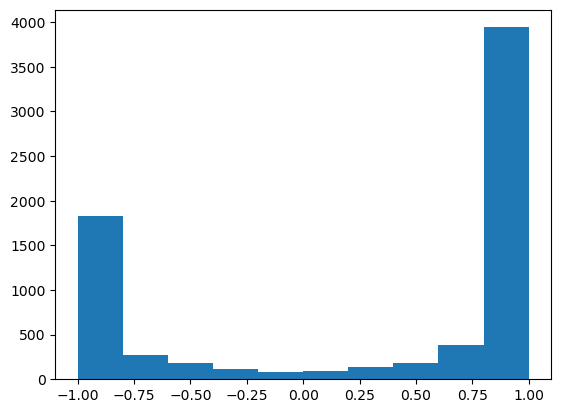

In [85]:
plt.hist(df_clean['sentiment_lyrics'])

In [86]:
df_clean

Artists                     Name  peak  max_weeks        Date  \
0            Ed Sheeran             Shape Of You     1         59  2017-01-28   
1     Justin Timberlake  Can't Stop The Feeling!     1         52  2016-05-28   
2          Taylor Swift             Shake It Off     1         50  2014-09-05   
3                 Drake               God's Plan     1         36  2018-02-03   
4         Justin Bieber        What Do You Mean?     1         31  2015-09-18   
...                 ...                      ...   ...        ...         ...   
7208            Shakira               Perro Fiel   100          1  2017-12-16   
7209               Beck                     Girl   100          1  2005-08-17   
7210      Nipsey Hussle              Victory Lap   100          1  2019-04-20   
7211          Rick Ross               Super High   100          1  2010-06-10   
7212             Halsey                Strangers   100          1  2017-06-17   

                                                  Genre  \
0                       Tropical House,Dancehall,Pop,UK   
1                                       Screen,Pop,R&;B   
2                                         Dance-Pop,Pop   
3                           Hip-Hop,Trap,Pop,Rap,Canada   
4      Canada,Tropical House,Electro-Pop,Electronic,Pop   
...                                                 ...   
7208                              En Espa\xc3\xb1ol,Pop   
7209  Adult Alternative,Pop-Rock,Experimental Folk,E...   
7210                                     West Coast,Rap   
7211                                                Rap   
7212  Alternative Pop,Alternative,Pop,Synth-Pop,Danc...   

                                                 Lyrics  Pop  Rap  Rock  ...  \
0     Shape of You The club isn't the best place to ...    1    0     0  ...   
1     CAN'T STOP THE FEELING! I got this feeling ins...    1    0     0  ...   
2     Shake It Off I stay out too lateGot nothing in...    1    0     0  ...   
3     God's Plan And they wishing and wishing and wi...    1    1     0  ...   
4     What Do You Mean? What do you mean? Oh, ohWhen...    1    0     0  ...   
...                                                 ...  ...  ...   ...  ...   
7208  Perro Fiel Aqui estasYa no puedes detenerte¿Do...    1    0     0  ...   
7209  Girl I saw her, yeah I saw her with her black ...    1    0     1  ...   
7210  Victory Lap Whoa, oh-whoa, whoa, ohhLike the b...    0    1     0  ...   
7211  Super High Remix You think you got the bond ca...    0    1     0  ...   
7212  Strangers She doesn't kiss me on the mouth any...    1    0     0  ...   

      Normalized Peak  Normalized Weeks  Popularity  Adjusted_popularity  \
0           11.714576          4.123389   15.837965            18.194849   
1           11.714576          3.485907   15.200483            17.557367   
2           11.714576          3.303769   15.018345            17.375229   
3           11.714576          2.028805   13.743381            16.100265   
4           11.714576          1.573460   13.288036            15.644920   
...               ...               ...         ...                  ...   
7208        -0.198278         -1.158606   -1.356884             1.000000   
7209        -0.198278         -1.158606   -1.356884             1.000000   
7210        -0.198278         -1.158606   -1.356884             1.000000   
7211        -0.198278         -1.158606   -1.356884             1.000000   
7212        -0.198278         -1.158606   -1.356884             1.000000   

      Log_popularity                                      tokens_lyrics  \
0           2.901139  [Shape, of, You, The, club, is, n't, the, best...   
1           2.865474  [CA, N'T, STOP, THE, FEELING, !, I, got, this,...   
2           2.855046  [Shake, It, Off, I, stay, out, too, lateGot, n...   
3           2.778836  [God, 's, Plan, And, they, wishing, and, wishi...   
4           2.750146  [What, Do, You, Mean, ?, What, do, you, mean, ...   
...       

In [87]:
df_clean.columns

Index(['Artists', 'Name', 'peak', 'max_weeks', 'Date', 'Genre', 'Lyrics',
       'Pop', 'Rap', 'Rock', 'R&;B', 'Country', 'Inverse Peak',
       'Normalized Peak', 'Normalized Weeks', 'Popularity',
       'Adjusted_popularity', 'Log_popularity', 'tokens_lyrics',
       'processed_lyrics', 'cleaned_lyrics', 'sentiment_lyrics',
       'sentiment_label_lyrics'],
      dtype='object')

In [88]:
df_clean['PopXsentiment'] = df_clean['Pop'] * df_clean['sentiment_lyrics']
df_clean['RapXsentiment'] = df_clean['Rap'] * df_clean['sentiment_lyrics']
df_clean['RockXsentiment'] = df_clean['Rock'] * df_clean['sentiment_lyrics']
df_clean['R&;BXsentiment'] = df_clean['R&;B'] * df_clean['sentiment_lyrics']
df_clean['CountryXsentiment'] = df_clean['Country'] * df_clean['sentiment_lyrics']

# XGBoost Regression with genre and sentiment ~ Popularity

In [89]:
feature_cols = ['sentiment_lyrics', 'Pop', 'Rap', 'Rock', 'R&;B', 'Country', 'PopXsentiment', 'RapXsentiment', 'RockXsentiment', 'R&;BXsentiment', 'CountryXsentiment']
#feature_cols = ['Pop', 'Rap', 'Rock', 'R&;B', 'Country', 'sentiment_lyrics']
#feature_cols = ['Pop', 'Rap', 'Rock', 'R&;B', 'Country']

In [90]:
X = df_clean[feature_cols]
y = df_clean['Log_popularity'].values
#break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=560)

In [91]:
gbm =  xgb.XGBRegressor()

In [92]:
gbm.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
y_pred = gbm.predict(X_test)

In [94]:
rmse = mean_squared_error(y_pred, y_test) ** (1/2)
rmse

0.534614429374306

In [95]:
r2_score(y_test, y_pred)

-0.05575351365310399

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

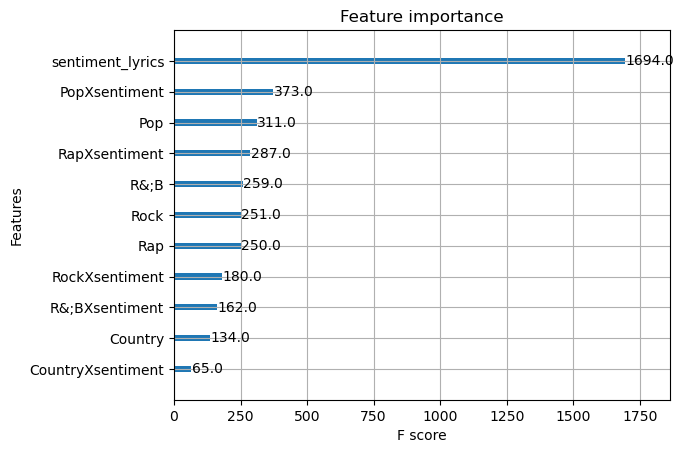

In [96]:
xgb.plot_importance(gbm)

# XGBoost Regression with Sentiment + Attributes ~ Popularity

In [97]:
# Using raw string literal for the file path
file_path = r'C:\Users\Yixuan Liu\Downloads\songAttributes_1999-2019.csv'

# Reading the CSV file into a DataFrame
att = pd.read_csv(file_path).reset_index(drop = True)

In [98]:
att['Name'] = att['Name'].str.lower()
df_clean['Name'] = df_clean['Name'].str.lower()

In [99]:
common = df_clean.merge(att, how = 'inner', left_on = ['Artists', 'Name'], right_on = ['Artist', 'Name'])
common = common.drop_duplicates(subset = 'Name').reset_index(drop = True)

In [100]:
common.columns

Index(['Artists', 'Name', 'peak', 'max_weeks', 'Date', 'Genre', 'Lyrics',
       'Pop', 'Rap', 'Rock', 'R&;B', 'Country', 'Inverse Peak',
       'Normalized Peak', 'Normalized Weeks', 'Popularity_x',
       'Adjusted_popularity', 'Log_popularity', 'tokens_lyrics',
       'processed_lyrics', 'cleaned_lyrics', 'sentiment_lyrics',
       'sentiment_label_lyrics', 'PopXsentiment', 'RapXsentiment',
       'RockXsentiment', 'R&;BXsentiment', 'CountryXsentiment', 'Unnamed: 0',
       'Acousticness', 'Album', 'Artist', 'Danceability', 'Duration', 'Energy',
       'Explicit', 'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
       'Popularity_y', 'Speechiness', 'Tempo', 'TimeSignature', 'Valence'],
      dtype='object')

In [101]:
common

Artists               Name  peak  max_weeks        Date  \
0         Ed Sheeran       shape of you     1         59  2017-01-28   
1       Taylor Swift       shake it off     1         50  2014-09-05   
2              Drake         god's plan     1         36  2018-02-03   
3      Justin Bieber  what do you mean?     1         31  2015-09-18   
4               Cher            believe     1         31  1999-07-12   
...              ...                ...   ...        ...         ...   
3324           3OH!3  i can do anything   100          1  2010-07-15   
3325  Ellie Goulding         explosions   100          1  2014-02-28   
3326         Pusha T  the games we play   100          1  2018-06-09   
3327            Beck               girl   100          1  2005-08-17   
3328       Rick Ross         super high   100          1  2010-06-10   

                                                  Genre  \
0                       Tropical House,Dancehall,Pop,UK   
1                                         Dance-Pop,Pop   
2                           Hip-Hop,Trap,Pop,Rap,Canada   
3      Canada,Tropical House,Electro-Pop,Electronic,Pop   
4                                             Dance,Pop   
...                                                 ...   
3324                                                Rap   
3325                                             UK,Pop   
3326                                     East Coast,Rap   
3327  Adult Alternative,Pop-Rock,Experimental Folk,E...   
3328                                                Rap   

                                                 Lyrics  Pop  Rap  Rock  ...  \
0     Shape of You The club isn't the best place to ...    1    0     0  ...   
1     Shake It Off I stay out too lateGot nothing in...    1    0     0  ...   
2     God's Plan And they wishing and wishing and wi...    1    1     0  ...   
3     What Do You Mean? What do you mean? Oh, ohWhen...    1    0     0  ...   
4     Believe After love, after loveAfter love, afte...    1    0     0  ...   
...                                                 ...  ...  ...   ...  ...   
3324  I Can Do Anything We can do an albumOr we can ...    0    1     0  ...   
3325  Explosions You trembled like you'd seen a ghos...    1    0     0  ...   
3326  The Games We Play Drug dealer Benzes with gold...    0    1     0  ...   
3327  Girl I saw her, yeah I saw her with her black ...    1    0     1  ...   
3328  Super High Remix You think you got the bond ca...    0    1     0  ...   

      Explicit  Instrumentalness  Liveness  Loudness  Mode  Popularity_y  \
0        False          0.000000    0.0931    -3.183     0            87   
1        False          0.000000    0.3340    -5.384     1            59   
2         True          0.000083    0.5520    -9.211     1            86   
3        False          0.000898    0.0849    -8.273     0            78   
4        False          0.000000    0.0509    -6.720     1            77   
...        ...               ...       ...       ...   ...           ...   
3324      True          0.000000    0.3680    -4.652     0             0   
3325     False          0.000000    0.3250    -6.562     1             1   
3326      True          0.016300    0.0960    -3.696     1            65   
3327     False          0.005200    0.1330    -6.582     1            37   
3328      True          0.000000    0.2160    -6.637     0            41   

      Speechiness    Tempo TimeSignature Valence  
0          0.0802   95.977             4   0.931  
1          0.1650  160.078             4   0.942  
2          0.1090   77.169             4   0.357  
3          0.0922  125.034             4   0.801  
4          0.0548  132.975             4   0.459  
...           ...      ...           ...     ...  
3324       0.2360  169.940             4   0.438  
3325       0.0304   95.192             4   0.166  
3326       0.1980   78.033             4   0.592  
3327       0.0962  149.616             4   0.859  
3328

In [102]:
features = ['sentiment_lyrics','Danceability', 'Speechiness', 'Energy', 'Loudness', 'Valence', 
            'Pop', 'Rap', 'Rock', 'R&;B', 'Country', 'PopXsentiment', 'RapXsentiment', 'RockXsentiment', 'R&;BXsentiment', 'CountryXsentiment']
target = ['Log_popularity']

In [103]:
X = common[features]
y = common[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=560)

In [104]:
gbm =  xgb.XGBRegressor()
gbm.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [105]:
y_pred = gbm.predict(X_test)
rmse = mean_squared_error(y_pred, y_test) ** (1/2)

D:\Anaconda\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [106]:
r2_score(y_test, y_pred)

D:\Anaconda\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



-0.20615590095361447

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

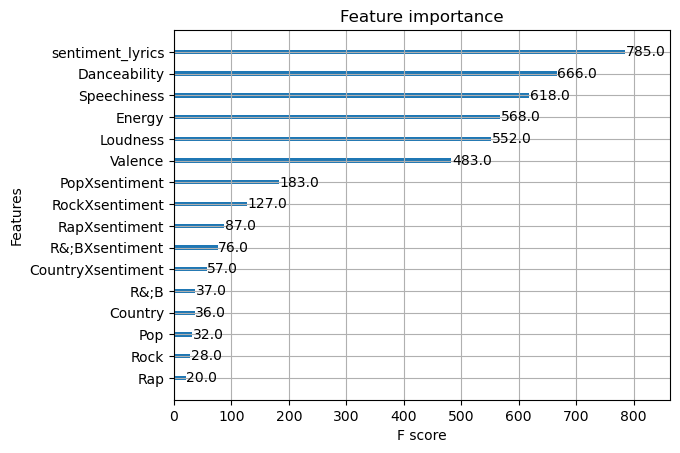

In [107]:
xgb.plot_importance(gbm)

# XGBoost Regression with TF-IDF ~ Popularity

In [108]:
X = df_clean['Lyrics'].values  # this time we want to look at the text
y = df_clean['Log_popularity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english')
vectorizer.fit(X)
X_train_tfidf = vectorizer.transform(X_train) # remember to use the original X_train set
X_test_tfidf = vectorizer.transform(X_test)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(5409, 164809)
(1804, 164809)


In [110]:
gbm.fit(X_train_tfidf, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [111]:
y_pred = gbm.predict(X_test_tfidf)

In [112]:
r2_score(y_test, y_pred)

-0.088242712214879

In [113]:
def r2(y_true, y_pred):
    """
    R^2 (coefficient of determination) regression score function.
    Best possible score is 1.0, lower values are worse.
    Args:
        y_true ([np.array]): test samples
        y_pred ([np.array]): predicted samples
    Returns:
        [float]: R2    
    """
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

In [114]:
r2(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.08824271198159317>

# NN Regression with genre and sentiment ~ Popularity

In [115]:
feature_cols = ['sentiment_lyrics', 'Pop', 'Rap', 'Rock', 'R&;B', 'Country', 'PopXsentiment', 'RapXsentiment', 'RockXsentiment', 'R&;BXsentiment', 'CountryXsentiment']
#feature_cols = ['Pop', 'Rap', 'Rock', 'R&;B', 'Country', 'sentiment_lyrics']
#feature_cols = ['Pop', 'Rap', 'Rock', 'R&;B', 'Country']

X = df_clean[feature_cols]
y = df_clean['Log_popularity'].values
#break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=560)

In [116]:
X_train.shape

(5770, 11)

In [117]:
model = Sequential()

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics = r2)

In [118]:
history = model.fit(X_train, y_train, 
          batch_size=64, epochs=10, verbose=1, 
          validation_split = 0.2)


Epoch 1/10
73/73 [==============================] - 1s 3ms/step - loss: 1.5657 - r2: 0.9344 - val_loss: 0.2838 - val_r2: 0.9425
Epoch 2/10
73/73 [==============================] - 0s 1ms/step - loss: 0.8620 - r2: 0.9670 - val_loss: 0.2476 - val_r2: 0.9687
Epoch 3/10
73/73 [==============================] - 0s 1ms/step - loss: 0.6256 - r2: 0.9763 - val_loss: 0.2478 - val_r2: 0.9715
Epoch 4/10
73/73 [==============================] - 0s 1ms/step - loss: 0.5183 - r2: 0.9819 - val_loss: 0.2458 - val_r2: 0.9691
Epoch 5/10
73/73 [==============================] - 0s 1ms/step - loss: 0.4296 - r2: 0.9855 - val_loss: 0.2430 - val_r2: 0.9704
Epoch 6/10
73/73 [==============================] - 0s 1ms/step - loss: 0.3825 - r2: 0.9871 - val_loss: 0.2431 - val_r2: 0.9699
Epoch 7/10
73/73 [==============================] - 0s 1ms/step - loss: 0.3385 - r2: 0.9890 - val_loss: 0.2416 - val_r2: 0.9731
Epoch 8/10
73/73 [==============================] - 0s 1ms/step - loss: 0.3164 - r2: 0.9902 - val_loss: 

In [119]:
y_pred = model.predict(X_test)

46/46 [==============================] - 0s 484us/step


In [120]:
y_pred.reshape(-1,)

array([0.8207208 , 0.8169608 , 0.5490947 , ..., 0.59508765, 0.5651791 ,
       0.53708184], dtype=float32)

In [121]:
y_test.reshape(-1,)

array([1.00485983, 0.04797996, 0.10139109, ..., 0.17266764, 1.00722395,
       0.02607148])

In [122]:
r2(y_test.reshape(-1,), y_pred.reshape(-1,))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0224706943270101>

# NN Regression with Word2Vec ~ Popularity

In [123]:
X = df_clean['Lyrics'].values  # this time we want to look at the text
y = df_clean['Log_popularity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [124]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize the text and create sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

# Pad sequences to ensure they all have the same length
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [125]:
# Define Word2Vec model
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
embedding_dim = 100  # Dimensionality of word embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Flatten())  # Flatten the 3D tensor to 2D for Dense layer

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1, activation='linear'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = [r2])

# Train the model
model.fit(padded_sequences, y_train, batch_size = 50, epochs=10, verbose=1)

Epoch 1/10
109/109 [==============================] - 22s 193ms/step - loss: 1.1511 - r2: 0.9414
Epoch 2/10
109/109 [==============================] - 21s 192ms/step - loss: 0.5881 - r2: 0.9732
Epoch 3/10
109/109 [==============================] - 20s 188ms/step - loss: 0.4392 - r2: 0.9819
Epoch 4/10
109/109 [==============================] - 21s 192ms/step - loss: 0.3616 - r2: 0.9857
Epoch 5/10
109/109 [==============================] - 21s 194ms/step - loss: 0.3210 - r2: 0.9880
Epoch 6/10
109/109 [==============================] - 21s 194ms/step - loss: 0.2972 - r2: 0.9892
Epoch 7/10
109/109 [==============================] - 21s 194ms/step - loss: 0.2791 - r2: 0.9902
Epoch 8/10
109/109 [==============================] - 21s 194ms/step - loss: 0.2762 - r2: 0.9905
Epoch 9/10
109/109 [==============================] - 21s 191ms/step - loss: 0.2683 - r2: 0.9909
Epoch 10/10
109/109 [==============================] - 21s 194ms/step - loss: 0.2650 - r2: 0.9910


In [126]:
# Tokenize the text and create sequences
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure they all have the same length
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [127]:
y_pred = model.predict(test_padded_sequences)

57/57 [==============================] - 1s 11ms/step


In [128]:
r2(y_test.reshape(-1,), y_pred.reshape(-1,))

<tf.Tensor: shape=(), dtype=float64, numpy=-0.03156086867540564>

# NN Regression with TF-IDF ~ Popularity

In [129]:
from scipy.sparse import csr_matrix
# Convert sparse matrices to dense matrices
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Reorder dense matrices
X_train_dense_reordered = np.sort(X_train_dense, axis=1)
X_test_dense_reordered = np.sort(X_test_dense, axis=1)

# Convert dense matrices back to sparse matrices
X_train_reordered_sparse = csr_matrix(X_train_dense_reordered)
X_test_reordered_sparse = csr_matrix(X_test_dense_reordered)

In [130]:
model = Sequential()

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics = [r2])

In [131]:
history = model.fit(X_train_reordered_sparse, y_train, 
          batch_size=64, epochs=10, verbose=1, 
          validation_data=(X_test_reordered_sparse, y_test))

Epoch 1/10
85/85 [==============================] - 4s 34ms/step - loss: 0.6843 - r2: 0.9750 - val_loss: 0.3650 - val_r2: 0.9886
Epoch 2/10
85/85 [==============================] - 3s 32ms/step - loss: 0.2792 - r2: 0.9923 - val_loss: 0.2659 - val_r2: 0.9933
Epoch 3/10
85/85 [==============================] - 3s 31ms/step - loss: 0.2477 - r2: 0.9938 - val_loss: 0.2594 - val_r2: 0.9937
Epoch 4/10
85/85 [==============================] - 3s 31ms/step - loss: 0.2470 - r2: 0.9939 - val_loss: 0.2591 - val_r2: 0.9937
Epoch 5/10
85/85 [==============================] - 3s 32ms/step - loss: 0.2468 - r2: 0.9940 - val_loss: 0.2590 - val_r2: 0.9937
Epoch 6/10
85/85 [==============================] - 3s 32ms/step - loss: 0.2469 - r2: 0.9939 - val_loss: 0.2589 - val_r2: 0.9937
Epoch 7/10
85/85 [==============================] - 3s 32ms/step - loss: 0.2469 - r2: 0.9939 - val_loss: 0.2597 - val_r2: 0.9937
Epoch 8/10
85/85 [==============================] - 2s 27ms/step - loss: 0.2470 - r2: 0.9938 - va

In [132]:
y_pred = model.predict(X_test_reordered_sparse)

57/57 [==============================] - 0s 698us/step


In [133]:
r2(y_test.reshape(-1,), y_pred.reshape(-1,))

<tf.Tensor: shape=(), dtype=float64, numpy=-0.00034655475757805476>

# XGBoost Classification with TF-IDF ~ Genre

In [134]:
'''# Transform the one-hot encoded columns back to a single column indicating the genre
df_clean['genre'] = df_clean[['Pop', 'Rap', 'Rock', 'R&;B', 'Country']].idxmax(axis=1)
df_clean['genre'].unique()'''

"# Transform the one-hot encoded columns back to a single column indicating the genre\ndf_clean['genre'] = df_clean[['Pop', 'Rap', 'Rock', 'R&;B', 'Country']].idxmax(axis=1)\ndf_clean['genre'].unique()"

In [135]:
'''lbe = LabelEncoder()
y = lbe.fit_transform(df_clean['genre'].values)'''

"lbe = LabelEncoder()\ny = lbe.fit_transform(df_clean['genre'].values)"

In [136]:
'''X = df_clean['Lyrics'].values  # this time we want to look at the text

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)'''

"X = df_clean['Lyrics'].values  # this time we want to look at the text\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)"

In [137]:
'''from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english')
vectorizer.fit(X)
X_train_tfidf = vectorizer.transform(X_train) # remember to use the original X_train set
X_test_tfidf = vectorizer.transform(X_test)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)'''

"from sklearn.feature_extraction.text import TfidfVectorizer\nvectorizer = TfidfVectorizer(stop_words = 'english')\nvectorizer.fit(X)\nX_train_tfidf = vectorizer.transform(X_train) # remember to use the original X_train set\nX_test_tfidf = vectorizer.transform(X_test)\nprint(X_train_tfidf.shape)\nprint(X_test_tfidf.shape)"

In [138]:
'''clf = xgb.XGBClassifier()
clf.fit(X_train_tfidf.tocsc(), y_train)'''

'clf = xgb.XGBClassifier()\nclf.fit(X_train_tfidf.tocsc(), y_train)'

In [139]:
'''y_pred = y_pred = clf.predict(X_test_tfidf)'''

'y_pred = y_pred = clf.predict(X_test_tfidf)'

In [140]:
'''accuracy_score(y_test, y_pred)'''

'accuracy_score(y_test, y_pred)'

# NN Classification with TF-IDF ~ Genre

In [141]:
'''# Transform the one-hot encoded columns back to a single column indicating the genre
df_clean['genre'] = df_clean[['Pop', 'Rap', 'Rock', 'R&;B', 'Country']].idxmax(axis=1)
df_clean['genre'].unique()

lbe = LabelEncoder()
y = lbe.fit_transform(df_clean['genre'].values)

X = df_clean['Lyrics'].values  # this time we want to look at the text

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)'''

"# Transform the one-hot encoded columns back to a single column indicating the genre\ndf_clean['genre'] = df_clean[['Pop', 'Rap', 'Rock', 'R&;B', 'Country']].idxmax(axis=1)\ndf_clean['genre'].unique()\n\nlbe = LabelEncoder()\ny = lbe.fit_transform(df_clean['genre'].values)\n\nX = df_clean['Lyrics'].values  # this time we want to look at the text\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)"

In [142]:
'''pd.Series(y).unique()'''

'pd.Series(y).unique()'

In [143]:
'''from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize the text and create sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

# Pad sequences to ensure they all have the same length
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')'''

"from keras.models import Sequential\nfrom keras.layers import Embedding, Dense, Flatten\nfrom keras.preprocessing.text import Tokenizer\nfrom keras.preprocessing.sequence import pad_sequences\n\n# Tokenize the text and create sequences\ntokenizer = Tokenizer()\ntokenizer.fit_on_texts(X_train)\nsequences = tokenizer.texts_to_sequences(X_train)\n\n# Pad sequences to ensure they all have the same length\nmax_length = max([len(seq) for seq in sequences])\npadded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')"

In [144]:
'''# Define Word2Vec model
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
embedding_dim = 100  # Dimensionality of word embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Flatten())  # Flatten the 3D tensor to 2D for Dense layer

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')

# Train the model
history = model.fit(padded_sequences, y_train, batch_size = 50, epochs=10, verbose=1, validation_split = 0.2)'''

"# Define Word2Vec model\nvocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token\nembedding_dim = 100  # Dimensionality of word embeddings\nmodel = Sequential()\nmodel.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))\nmodel.add(Flatten())  # Flatten the 3D tensor to 2D for Dense layer\n\nmodel.add(Dense(512, activation='relu'))\nmodel.add(Dropout(0.3))\nmodel.add(BatchNormalization())\n\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dropout(0.3))\nmodel.add(BatchNormalization())\n\nmodel.add(Dense(5, activation='softmax'))  # Output layer\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')\n\n# Train the model\nhistory = model.fit(padded_sequences, y_train, batch_size = 50, epochs=10, verbose=1, validation_split = 0.2)"

In [145]:
'''test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure they all have the same length
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')
predictions = model.predict(padded_test_sequences)'''

"test_sequences = tokenizer.texts_to_sequences(X_test)\n\n# Pad sequences to ensure they all have the same length\npadded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')\npredictions = model.predict(padded_test_sequences)"

In [146]:
'''y_pred = np.argmax(predictions, axis=1)'''

'y_pred = np.argmax(predictions, axis=1)'

In [147]:
'''y_pred.shape'''

'y_pred.shape'

In [148]:
'''accuracy_score(y_test, y_pred)'''

'accuracy_score(y_test, y_pred)'

In [149]:
'''# plot the trainng and validation errors
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation errors')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Trainning error', 'Validation error'], loc='upper right')
plt.show()'''

"# plot the trainng and validation errors\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('Training and validation errors')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['Trainning error', 'Validation error'], loc='upper right')\nplt.show()"

In [150]:
'''# plot the trainng and validation errors
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation errors')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()'''

"# plot the trainng and validation errors\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('Training and validation errors')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['Accuracy', 'Validation Accuracy'], loc='upper right')\nplt.show()"